# **Textual Analysis within the Ditchley Conference Archives Leveraging BERTopic Modelling**

#Preparation

In [ ]:
# Set wrap output text
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import re
import json
import joblib
import pickle
import unicodedata
import nltk
from nltk import tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Mounting gdrive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Enable data table display for gcolab
from google.colab import data_table
data_table.enable_dataframe_formatter()

pd.set_option('mode.chained_assignment', None)

In [ ]:
# Setting parameter
min_characters_para = 150   # Min characters in a paragraph (inclusive)
min_characters_word = 10     # Min characters in a word (inclusive)

#Pre-Processing

## Normalising the summary text

We first load the Ditchley corpus we collected using the Ditchley scrapper we built previously.

In [ ]:
# Loading json
with open('gdrive/MyDrive/Ditchley001/Data2/ditchley_corpus.json', 'r') as fp:
  ditchley_corpus = json.load(fp)

In [ ]:
# See dict structure
ditchley_corpus

In [ ]:
for item in ditchley_corpus:
  # Normalise summary text
  item['summary'] = unicodedata.normalize("NFKD", item['summary'])

  # Cut participants list section
  try:
    idx = re.search(r"(This ([Nn]ote|report) reflects the (Director|Chairman|personal))|(PARTICIPANTS CHAIR ?)|(PARTICIPANTSCHAIR:|(PARTICIPANTS)|([Cc][Hh][Aa][Ii][Rr]\s?:)|(© The Ditchley Foundation, \d{4}))",
                    item['summary']).start()
    item['summary'] = item['summary'][:idx]
  except:
    pass

## Splitting summary into paragraphs

For prediction purpose, we will split the text into paragraphs and filter out paragraphs that have less than minimum 150 characters per paragraph.

**Update:**
We meet some conditions where multiple white spaces in the paragraph text ("  ") has caused problem in the sentence tokenisation of the paragraph in the paragraph split process. Therefore, we use regex to normalise the text by replacing the multiple white spaces with one single white space.

In [ ]:
# Create a function to fix whitespace
def fix_whitespace(raw_para):
  para = re.sub("\s{2,}", " ", raw_para) # replace multiple whitespaces with a single whitespace
  para = para.strip() # remove whitespaces at the beginning and at the end of the string
  return para

In [ ]:
# Split the summary text into paragraphs
ditchley_corpus_para = []

for item in ditchley_corpus:
  for para in item['summary'].split('\n\n'):
    summary_para = dict()

    summary_para['period'] = item['period']
    summary_para['year'] = item['year']
    summary_para['title'] = item['title']
    summary_para['link'] = item['link']
    summary_para['para_text'] = fix_whitespace(para) # Get paragraph text
    summary_para['para_len'] = len(fix_whitespace(para)) # Get paragraph length

    ditchley_corpus_para.append(summary_para)

In [ ]:
# Create dataframe from dictionary
df_ditchley_para = pd.DataFrame(ditchley_corpus_para)

# Count the number of paragraph and article title before filtering
print(f"Number of paragraphs: {df_ditchley_para.shape[0]}")
print(f"Number of articles: {df_ditchley_para.title.nunique()}")

Number of paragraphs: 15060
Number of articles: 518


In [ ]:
#How many articles in each period
unique_titles_per_period = df_ditchley_para.groupby('period')['title'].nunique()
df_unique_titles = unique_titles_per_period.reset_index().rename(columns={"title": "number of titles"})
print(df_unique_titles)


        period  number of titles
0  1962 - 1969                13
1  1970 - 1979                 9
2  1980 - 1989                68
3  1990 - 1999               156
4  2000 - 2009               126
5  2010 - 2019               119
6  2020 - 2029                27


In [ ]:
df_unique_titles

period  number of titles
0  1962 - 1969                13
1  1970 - 1979                 9
2  1980 - 1989                68
3  1990 - 1999               156
4  2000 - 2009               126
5  2010 - 2019               119
6  2020 - 2029                27

In [ ]:
# Count of 'para_text' in each period
para_text_count = df_ditchley_para.groupby('period')['para_text'].count()

# Convert the series to a DataFrame and rename the column
df_para_text_count = para_text_count.reset_index().rename(columns={"para_text": "number of para_text"})

# Merge the two DataFrames
df_final = pd.merge(df_unique_titles, df_para_text_count, on='period')
print(df_final)


        period  number of titles  number of para_text
0  1962 - 1969                13                  603
1  1970 - 1979                 9                  454
2  1980 - 1989                68                 1232
3  1990 - 1999               156                 2609
4  2000 - 2009               126                 2982
5  2010 - 2019               119                 6502
6  2020 - 2029                27                  678


In [ ]:
df_final

period  number of titles  number of para_text
0  1962 - 1969                13                  603
1  1970 - 1979                 9                  454
2  1980 - 1989                68                 1232
3  1990 - 1999               156                 2609
4  2000 - 2009               126                 2982
5  2010 - 2019               119                 6502
6  2020 - 2029                27                  678

In [ ]:
df_ditchley_para

Output hidden; open in https://colab.research.google.com to view.

## Filtering and splitting paragraph

We first filter out paragraphs with less than minimum number of characters (150 characters).

In [ ]:
# Filter out paragraphs with minimum character parameter.
df_ditchley_para = df_ditchley_para[df_ditchley_para['para_len'] >= 150].reset_index(drop=True)

print(f"Number of paragraph after filtering: {df_ditchley_para.shape[0]}")
print(f"Number of articles after filtering: {df_ditchley_para.title.nunique()}")

Number of paragraph after filtering: 11767
Number of articles after filtering: 510


We then split the paragraphs that have long text into minimum 150 characters.

In [ ]:
# Splitting paragraph into minimum 150 characters
df_ditchley_para_split = pd.DataFrame()

for i in df_ditchley_para.index:
  sentences = tokenize.sent_tokenize(df_ditchley_para['para_text'][i])
  paragraphs = []

  j = 0
  while j < len(sentences):
    current_para = ''
    while len(current_para) < min_characters_para: #j=0 len=0 | j=1 len=88 | j=2 len=217
      try:
        current_para = (current_para + ' ' + sentences[j]).strip()
        j += 1
      except:
        break

    if len(current_para) >= min_characters_para:
      paragraphs.append(current_para)
    else:
      paragraphs[-1] = paragraphs[-1] + ' ' + current_para

  # Add paragraph to paragraph_list
  for paragraph in paragraphs:
      df_ditchley_para_split = df_ditchley_para_split.append({'period': df_ditchley_para['period'][i],
                                                              'year': df_ditchley_para['year'][i],
                                                              'title': df_ditchley_para['title'][i],
                                                              'link': df_ditchley_para['link'][i],
                                                              'para_text': paragraph,
                                                              'para_len': int(len(paragraph))},
                                                             ignore_index=True)

In [ ]:
print(f"Number of paragraph after splitting: {df_ditchley_para_split.shape[0]}")
print(f"Number of articles after filtering: {df_ditchley_para_split.title.nunique()}")

Number of paragraph after splitting: 32527
Number of articles after filtering: 510


The number of paragraphs after filtering are 32,527
paragraphs that comes from 510 articles.

In [ ]:
df_ditchley_para_split.head()

period  year                                  title  \
0  2020 - 2029  2022  Ditchley Regional Devolution Briefing   
1  2020 - 2029  2022  Ditchley Regional Devolution Briefing   
2  2020 - 2029  2022  Ditchley Regional Devolution Briefing   
3  2020 - 2029  2022  Ditchley Regional Devolution Briefing   
4  2020 - 2029  2022  Ditchley Regional Devolution Briefing   

                                                link  \
0  https://www.ditchley.com/programme/past-events...   
1  https://www.ditchley.com/programme/past-events...   
2  https://www.ditchley.com/programme/past-events...   
3  https://www.ditchley.com/programme/past-events...   
4  https://www.ditchley.com/programme/past-events...   

                                           para_text  para_len  
0  Following Ditchley’s June 2021 conference Take...       357  
1  The conference gave rise to a pilot programme ...       313  
2  On Monday 4th April, we summarised Ditchley's ...       180  
3  In the Ditchley tradition, the paper draws on ...       204  
4  The paper does not seek to make prescriptive r...       250

In [ ]:
# Group by 'period' and apply custom aggregations
summary_table = df_ditchley_para_split.groupby('period').agg(
    Number_of_Articles=pd.NamedAgg(column='title', aggfunc=lambda x: x.nunique()),
    Number_of_Paragraphs=pd.NamedAgg(column='para_text', aggfunc='size')
).reset_index()

# Rename 'period' column to 'Period'
summary_table.rename(columns={'period': 'Period'}, inplace=True)

# Display the resulting table
summary_table


## Text cleansing

The text cleansing process includes removing punctuations and special characters, converting to lowercase, removing stopwords, and lemmatisation.

In [ ]:
# Create function for cleaning the text
def cleanText(text):
  # Keep only words
  text = re.sub("[^a-zA-Z]", " ", text)

  # Convert to lower case and split
  text = text.lower().split()

  # Remove stopwords
  tokens = []
  for word in text:
    if (len(word) >= 3) & (word not in stop_words) : tokens.append(word) # min_characters_word = 3

  # Lemmatise words
  lm = WordNetLemmatizer()
  stemmed_words = [lm.lemmatize(w) for w in tokens]

  # Join the cleaned words
  cleaned_text = " ".join(stemmed_words)

  return cleaned_text

In [ ]:
# Apply text cleaning
df_ditchley_para_split['para_text_cleaned'] = df_ditchley_para_split['para_text'].apply(cleanText)

In [ ]:
df_ditchley_para_split.head()

period  year                                  title  \
0  2020 - 2029  2022  Ditchley Regional Devolution Briefing   
1  2020 - 2029  2022  Ditchley Regional Devolution Briefing   
2  2020 - 2029  2022  Ditchley Regional Devolution Briefing   
3  2020 - 2029  2022  Ditchley Regional Devolution Briefing   
4  2020 - 2029  2022  Ditchley Regional Devolution Briefing   

                                                link  \
0  https://www.ditchley.com/programme/past-events...   
1  https://www.ditchley.com/programme/past-events...   
2  https://www.ditchley.com/programme/past-events...   
3  https://www.ditchley.com/programme/past-events...   
4  https://www.ditchley.com/programme/past-events...   

                                           para_text  para_len  \
0  Following Ditchley’s June 2021 conference Take...       357   
1  The conference gave rise to a pilot programme ...       313   
2  On Monday 4th April, we summarised Ditchley's ...       180   
3  In the Ditchley tradition, the paper draws on ...       204   
4  The paper does not seek to make prescriptive r...       250   

                                   para_text_cleaned  
0  following ditchley june conference take back c...  
1  conference gave rise pilot programme conversat...  
2  monday april summarised ditchley regionalism w...  
3  ditchley tradition paper draw series conversat...  
4  paper seek make prescriptive recommendation bu...

In [ ]:
# Save prediction result
df_ditchley_para_split.to_csv("gdrive/MyDrive/Ditchley001/Data2/Data_split150.csv", index=False)

In [ ]:
df = df_ditchley_para_split

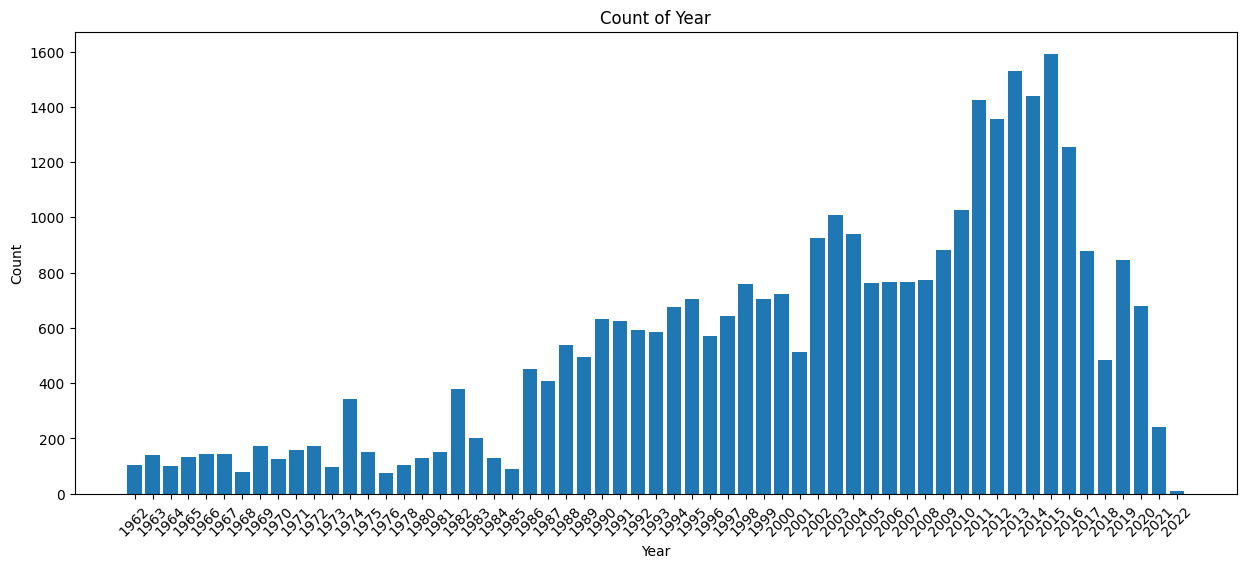

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'df' containing the data

# Count the occurrences of each year in the 'year' column
year_counts = df['year'].value_counts()

# Sort the counts by year in ascending order
year_counts = year_counts.sort_index()

# Set the figure size
plt.figure(figsize=(15, 6))  # Adjust the width and height as needed

# Create the bar plot
plt.bar(year_counts.index, year_counts.values)

# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Year')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
plt.show()


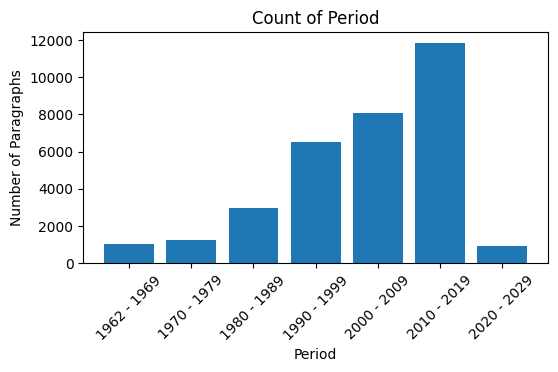

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'df' containing the data

# Count the occurrences of each year in the 'period year' column
year_counts = df['period'].value_counts()

# Sort the counts by year in ascending order
year_counts = year_counts.sort_index()

# Set the figure size
plt.figure(figsize=(6, 3))  # Adjust the width and height as needed

# Create the bar plot
plt.bar(year_counts.index, year_counts.values)

# Add labels and title to the plot
plt.xlabel('Period')
plt.ylabel('Number of Paragraphs')
plt.title('Count of Period')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
plt.show()


# BERTopic

In [ ]:
!pip install bertopic


In [ ]:
import re
import pandas as pd
from bertopic import BERTopic

## Import data


In [ ]:
# shortcut for redownloading prepared data

df = pd.read_csv('gdrive/MyDrive/Ditchley001/Data2/Data_split150.csv')

In [ ]:
import pandas as pd
# create a new column 'word_count'
df['word_count'] = df['para_text_cleaned'].apply(lambda x: len(str(x).split()))


In [ ]:
average_word_count = df['word_count'].mean()
average_word_count

21.9076459556676

In [ ]:
# Group by 'period' and apply custom aggregations
summary_table = df.groupby('period').agg(
    Number_of_Articles=pd.NamedAgg(column='title', aggfunc=lambda x: x.nunique()),
    Number_of_Paragraphs=pd.NamedAgg(column='para_text', aggfunc='size')
).reset_index()

# Rename 'period' column to 'Period'
summary_table.rename(columns={'period': 'Period'}, inplace=True)

# Display the resulting table
summary_table


Period  Number_of_Articles  Number_of_Paragraphs
0  1962 - 1969                  13                  1020
1  1970 - 1979                   9                  1221
2  1980 - 1989                  68                  2971
3  1990 - 1999                 156                  6493
4  2000 - 2009                 126                  8058
5  2010 - 2019                 119                 11831
6  2020 - 2029                  19                   933

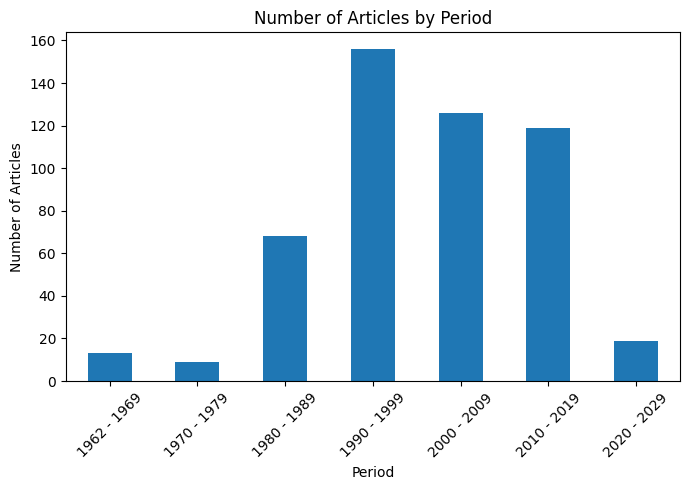

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the bar graph with a specified figure size
summary_table.plot(x='Period', y='Number_of_Articles', kind='bar', legend=False, figsize=(7, 5))
plt.ylabel('Number of Articles')
plt.title('Number of Articles by Period')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


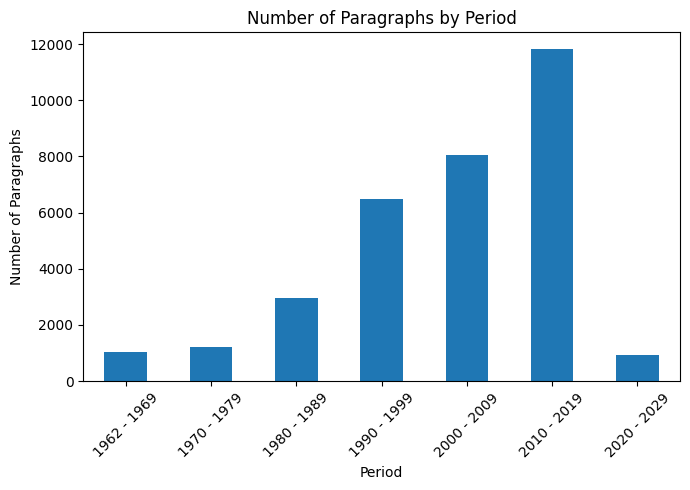

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the bar graph with a specified figure size
summary_table.plot(x='Period', y='Number_of_Paragraphs', kind='bar', legend=False, figsize=(7, 5))
plt.ylabel('Number of Paragraphs')
plt.title('Number of Paragraphs by Period')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
df

period  year                                              title  \
0      2020 - 2029  2022              Ditchley Regional Devolution Briefing   
1      2020 - 2029  2022              Ditchley Regional Devolution Briefing   
2      2020 - 2029  2022              Ditchley Regional Devolution Briefing   
3      2020 - 2029  2022              Ditchley Regional Devolution Briefing   
4      2020 - 2029  2022              Ditchley Regional Devolution Briefing   
...            ...   ...                                                ...   
32522  1962 - 1969  1962  The impact of European integration on Commonwe...   
32523  1962 - 1969  1962  The impact of European integration on Commonwe...   
32524  1962 - 1969  1962  The impact of European integration on Commonwe...   
32525  1962 - 1969  1962  The impact of European integration on Commonwe...   
32526  1962 - 1969  1962  The impact of European integration on Commonwe...   

                                                    link  \
0      https://www.ditchley.com/programme/past-events...   
1      https://www.ditchley.com/programme/past-events...   
2      https://www.ditchley.com/programme/past-events...   
3      https://www.ditchley.com/programme/past-events...   
4      https://www.ditchley.com/programme/past-events...   
...                                                  ...   
32522  https://www.ditchley.com/past-events/past-prog...   
32523  https://www.ditchley.com/past-events/past-prog...   
32524  https://www.ditchley.com/past-events/past-prog...   
32525  https://www.ditchley.com/past-events/past-prog...   
32526  https://www.ditchley.com/past-events/past-prog...   

                                               para_text  para_len  \
0      Following Ditchley’s June 2021 conference Take...       357   
1      The conference gave rise to a pilot programme ...       313   
2      On Monday 4th April, we summarised Ditchley's ...       180   
3      In the Ditchley tradition, the paper draws on ...       204   
4      The paper does not seek to make prescriptive r...       250   
...                                                  ...       ...   
32522  This is something quite different from associa...       182   
32523  It has great advantages over both. In the firs...       287   
32524  are not required. But above all is the conside...       279   
32525  This plan was first put forward publicly at an...       209   
32526  It is a proposal which, if pursued vigorously,...       238   

                                       para_text_cleaned  word_count  
0      following ditchley june conference take back c...          35  
1      conference gave rise pilot programme conversat...          26  
2      monday april summarised ditchley regionalism w...          17  
3      ditchley tradition paper draw series conversat...          18  
4      paper seek make prescriptive recommendation bu...          21  
...                                                  ...         ...  
32522  something quite different associate membership...          15  
32523  great advantage first place negotiation commis...          20  
32524  required consideration negotiating strength ag...          19  
32525  plan first put forward publicly anglo american...          19  
32526  proposal pursued vigorously might provide insp...          22  

[32527 rows x 8 columns]

In [ ]:
# Prepare data

df.para_text_cleaned = df.apply(lambda row: re.sub(r"http\S+", "", row.para_text_cleaned).lower(), 1)
df.para_text_cleaned = df.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.para_text_cleaned.split())), 1)
df.para_text_cleaned = df.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.para_text_cleaned).split()), 1)
timestamps = df.year.to_list()
tweets = df.para_text_cleaned.to_list()

In [ ]:
!pip install gensim


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary  # Importing the Dictionary class from Gensim

nltk.download('punkt')  # download the punkt tokenizer

# Assuming 'tweets' is a list of your tweet strings
tokenized_tweets = [word_tokenize(tweet) if tweet else [] for tweet in tweets]

# Now, create the Gensim dictionary and corpus
dictionary = Dictionary(tokenized_tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in tokenized_tweets]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(tokenized_tweets[:5])

[['following', 'ditchley', 'june', 'conference', 'take', 'back', 'control', 'part', 'two', 'need', 'done', 'renew', 'british', 'people', 'sense', 'democratic', 'agency', 'economic', 'opportunity', 'across', 'country', 'continued', 'explore', 'topic', 'regional', 'devolution', 'england', 'informed', 'international', 'perspective', 'germany', 'france', 'united', 'state', 'canada'], ['conference', 'gave', 'rise', 'pilot', 'programme', 'conversation', 'visit', 'north', 'east', 'england', 'ensure', 'ditchley', 'global', 'conversation', 'renewal', 'democracy', 'complemented', 'informed', 'conversation', 'democracy', 'democratic', 'state', 'working', 'regional', 'local', 'level'], ['monday', 'april', 'summarised', 'ditchley', 'regionalism', 'work', 'point', 'time', 'presented', 'interim', 'regional', 'devolution', 'paper', 'hybrid', 'ditchley', 'community', 'audience'], ['ditchley', 'tradition', 'paper', 'draw', 'series', 'conversation', 'expert', 'opinion', 'former', 'policy', 'maker', 'supp

In [ ]:
from gensim.corpora.dictionary import Dictionary

# Create a dictionary
dictionary = Dictionary(tokenized_tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in tokenized_tweets]

## Modeling

---



In [ ]:
# Create topics
model = BERTopic(verbose=True, nr_topics=50)
topics, probs = model.fit_transform(tweets)


Batches:   0%|          | 0/1017 [00:00<?, ?it/s]

2023-08-02 22:33:30,456 - BERTopic - Transformed documents to Embeddings
2023-08-02 22:33:55,439 - BERTopic - Reduced dimensionality
2023-08-02 22:34:00,996 - BERTopic - Clustered reduced embeddings
2023-08-02 22:34:03,639 - BERTopic - Reduced number of topics from 213 to 50


##Save Model


In [ ]:
# Method 1 - safetensors
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
model_folder_path = "gdrive/MyDrive/Ditchley001/Model/"
model_file_name = "my_bertopic_model_Final002"
model.save(model_folder_path + model_file_name, serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

##Download Model

In [ ]:
# Mounting gdrive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install bertopic

In [ ]:
from bertopic import BERTopic

# Load from directory
model_folder_path = "gdrive/MyDrive/Ditchley001/Model/"
model_file_name = "my_bertopic_model_Final002"
model = BERTopic.load(model_folder_path + model_file_name)

## Topic Info

###All information

In [ ]:
model.get_topic_info()

Topic  Count                                               Name  \
0      -1  16126                         -1_would_could_country_one   
1       0   2735                        0_russia_nato_soviet_turkey   
2       1   1639                       1_japan_china_africa_african   
3       2   1059                         2_law_scotland_right_court   
4       3   1035                      3_currency_bank_rate_monetary   
5       4    980                   4_european_europe_germany_german   
6       5    807                  5_water_environmental_oil_climate   
7       6    792                  6_education_university_ngo_school   
8       7    567               7_democracy_president_obama_american   
9       8    483                      8_data_privacy_internet_cyber   
10      9    429             9_nuclear_weapon_defence_proliferation   
11     10    426                 10_muslim_terrorism_islam_religion   
12     11    425               11_refugee_asylum_migration_minority   
13     12    401                        12_trade_wto_doha_agreement   
14     13    401         13_ditchley_conference_chairman_foundation   
15     14    383                      14_drug_prison_crime_prisoner   
16     15    377           15_journalism_party_newspaper_journalist   
17     16    321                  16_health_care_healthcare_patient   
18     17    296                   17_inequality_pension_income_age   
19     18    294            18_science_scientific_genetic_scientist   
20     19    248       19_manufacturing_technology_internet_digital   
21     20    247                     20_brazil_mexico_latin_america   
22     21    246                    21_pandemic_risk_disaster_covid   
23     22    214                     22_city_transport_road_tourism   
24     23    211                      23_man_god_universal_leonardo   
25     24    193             24_chairman_shareholder_director_board   
26     25    187                     25_family_woman_child_marriage   
27     26    164        26_food_agriculture_agricultural_production   
28     27    143                      27_art_museum_heritage_artist   
29     28    117                       28_ocean_data_marine_fishing   
30     29     74           29_moral_philosophy_philosopher_morality   
31     30     74                    30_arctic_antarctic_council_ice   
32     31     72            31_drone_technology_surveillance_strike   
33     32     44                  32_trust_institution_distrust_lie   
34     33     38                         33_beetle_cell_mimosa_tree   
35     34     37                  34_canada_canadian_british_united   
36     35     36                         35_brain_mind_music_nature   
37     36     33                 36_optimism_pessimism_gloomy_gloom   
38     37     32                  37_space_competition_orbit_nation   
39     38     17                     38_earth_planet_moon_biosphere   
40     39     16               39_guantanamo_court_torture_torturer   
41     40     14              40_patent_patenting_advantage_product   
42     41     13                   41_growth_anger_period_prolonged   
43     42     13        42_merger_consolidation_acquisition_digital   
44     43     13                      43_hiv_positive_aid_insurance   
45     44     12  44_recommendation_practical_encompassing_recom...   
46     45     11                  45_speech_hate_freedom_defamation   
47     46     11      46_detergent_phosphate_housewife_manufacturer   
48     47     11               47_hesburgh_father_remedy_profession   
49     48     10               48_ammunition_gun_manufacture_weapon   

                                       Representation  Representative_Docs  
0   [would, could, country, one, government, might...                  NaN  
1   [russia, nato, soviet, turkey, would, iran, ru...                  NaN  
2   [japan, china, africa, african, chinese, japan...                  NaN  
3   [law, scotland, right, court, constitution, hu...                  NaN

In [ ]:
model.get_document_info(tweets)

Document  Topic  \
0      following ditchley june conference take back c...     -1   
1      conference gave rise pilot programme conversat...     -1   
2      monday april summarised ditchley regionalism w...     13   
3      ditchley tradition paper draw series conversat...     13   
4      paper seek make prescriptive recommendation bu...     44   
...                                                  ...    ...   
32522  something quite different associate membership...     -1   
32523  great advantage first place negotiation commis...     12   
32524  required consideration negotiating strength ag...     -1   
32525  plan first put forward publicly anglo american...     -1   
32526  proposal pursued vigorously might provide insp...     -1   

                                                    Name  \
0                             -1_would_could_country_one   
1                             -1_would_could_country_one   
2             13_ditchley_conference_chairman_foundation   
3             13_ditchley_conference_chairman_foundation   
4      44_recommendation_practical_encompassing_recom...   
...                                                  ...   
32522                         -1_would_could_country_one   
32523                        12_trade_wto_doha_agreement   
32524                         -1_would_could_country_one   
32525                         -1_would_could_country_one   
32526                         -1_would_could_country_one   

                                          Representation  \
0      [would, could, country, one, government, might...   
1      [would, could, country, one, government, might...   
2      [ditchley, conference, chairman, foundation, w...   
3      [ditchley, conference, chairman, foundation, w...   
4      [recommendation, practical, encompassing, reco...   
...                                                  ...   
32522  [would, could, country, one, government, might...   
32523  [trade, wto, doha, agreement, round, multilate...   
32524  [would, could, country, one, government, might...   
32525  [would, could, country, one, government, might...   
32526  [would, could, country, one, government, might...   

                                     Representative_Docs  \
0      [likely attract wide political support also co...   
1      [likely attract wide political support also co...   
2      [conference held ditchley park september calle...   
3      [conference held ditchley park september calle...   
4      [comparatively specific practical recommendati...   
...                                                  ...   
32522  [likely attract wide political support also co...   
32523  [free trade agreement actually increase trade ...   
32524  [likely attract wide political support also co...   
32525  [likely attract wide political support also co...   
32526  [likely attract wide political support also co...   

                                             Top_n_words  Probability  \
0      would - could - country - one - government - m...     0.000000   
1      would - could - country - one - government - m...     0.000000   
2      ditchley - conference - chairman - foundation ...     1.000000   
3      ditchley - conference - chairman - foundation ...     0.691051   
4      recommendation - practical - encompassing - re...     1.000000   
...                                                  ...          ...   
32522  would - could - country - one - government - m...     0.000000   
32523  trade - wto - doha - agreement - round - multi...     1.000000   
32524  would - could - country - one - government - m...     0.000000   
32525  would - could - country - one - government - m...     0.000000   
32526  would - could - country - one - government - m...     0.000000   

       Representative_document  
0                        False  
1                        False  
2                        False  
3                        False  
4                        False  
...  

In [ ]:
import pandas as pd

# Get document information
document_info = model.get_document_info(tweets)

# Convert document information to a DataFrame
df_document_info = pd.DataFrame(document_info)



In [ ]:
df_document_info

Document  Topic  \
0      following ditchley june conference take back c...     -1   
1      conference gave rise pilot programme conversat...     -1   
2      monday april summarised ditchley regionalism w...     13   
3      ditchley tradition paper draw series conversat...     13   
4      paper seek make prescriptive recommendation bu...     44   
...                                                  ...    ...   
32522  something quite different associate membership...     -1   
32523  great advantage first place negotiation commis...     12   
32524  required consideration negotiating strength ag...     -1   
32525  plan first put forward publicly anglo american...     -1   
32526  proposal pursued vigorously might provide insp...     -1   

                                                    Name  \
0                             -1_would_could_country_one   
1                             -1_would_could_country_one   
2             13_ditchley_conference_chairman_foundation   
3             13_ditchley_conference_chairman_foundation   
4      44_recommendation_practical_encompassing_recom...   
...                                                  ...   
32522                         -1_would_could_country_one   
32523                        12_trade_wto_doha_agreement   
32524                         -1_would_could_country_one   
32525                         -1_would_could_country_one   
32526                         -1_would_could_country_one   

                                          Representation  \
0      [would, could, country, one, government, might...   
1      [would, could, country, one, government, might...   
2      [ditchley, conference, chairman, foundation, w...   
3      [ditchley, conference, chairman, foundation, w...   
4      [recommendation, practical, encompassing, reco...   
...                                                  ...   
32522  [would, could, country, one, government, might...   
32523  [trade, wto, doha, agreement, round, multilate...   
32524  [would, could, country, one, government, might...   
32525  [would, could, country, one, government, might...   
32526  [would, could, country, one, government, might...   

                                     Representative_Docs  \
0      [likely attract wide political support also co...   
1      [likely attract wide political support also co...   
2      [conference held ditchley park september calle...   
3      [conference held ditchley park september calle...   
4      [comparatively specific practical recommendati...   
...                                                  ...   
32522  [likely attract wide political support also co...   
32523  [free trade agreement actually increase trade ...   
32524  [likely attract wide political support also co...   
32525  [likely attract wide political support also co...   
32526  [likely attract wide political support also co...   

                                             Top_n_words  Probability  \
0      would - could - country - one - government - m...     0.000000   
1      would - could - country - one - government - m...     0.000000   
2      ditchley - conference - chairman - foundation ...     1.000000   
3      ditchley - conference - chairman - foundation ...     0.691051   
4      recommendation - practical - encompassing - re...     1.000000   
...                                                  ...          ...   
32522  would - could - country - one - government - m...     0.000000   
32523  trade - wto - doha - agreement - round - multi...     1.000000   
32524  would - could - country - one - government - m...     0.000000   
32525  would - could - country - one - government - m...     0.000000   
32526  would - could - country - one - government - m...     0.000000   

       Representative_document  
0                        False  
1                        False  
2                        False  
3                        False  
4                        False  
...  

In [ ]:
# Export DataFrame to CSV
df_document_info.to_csv('gdrive/MyDrive/Ditchley001/Finalresult/alltopiclist.csv', index=False)

### Topic Summary including -1

In [ ]:
import pandas as pd

# Assuming you have already loaded your DataFrame, df_document_info

# Filter rows where Topic column is equal to -1
filtered_df = df_document_info[df_document_info['Topic'] == -1]

# Get 10 random samples from the filtered DataFrame
sampled_data = filtered_df.sample(10)[['Document']]

# Reset the index and add a 'Sample No' column
sampled_data.reset_index(drop=True, inplace=True)
sampled_data.index += 1
sampled_data.rename_axis('Sample No', inplace=True)

# Print the table
sampled_data


Document
Sample No                                                   
1          course two day discussion found constantly cir...
2          one persistent issue need improve quality publ...
3          easy withhold comment information could verifi...
4          purpose article quoted confine intervention ca...
5          mounting expectation sector imposed acknowledg...
6          problem military standpoint viewed see militar...
7          reminded nevertheless issue like shaping arm c...
8          good likely predicting avoiding next crisis ai...
9          shifting balance military role might pose awkw...
10         campaign primarily moral choice involved aimed...

In [ ]:
#Topic Summary

import pandas as pd

# Assuming you have a DataFrame named df_document_info with columns 'Name' and 'Topic'

# Calculate the frequency of each unique item in the 'Name' column, grouped by 'Topic'
dfcount = df_document_info.groupby(['Topic', 'Name']).size().reset_index(name='Count')

# Calculate the total count of all rows
total_count = dfcount['Count'].sum()

# Calculate the proportion by dividing the 'Count' by the total count and multiplying by 100
dfcount['Proportion'] = (dfcount['Count'] / total_count) * 100

# Round the 'Proportion' column to two decimal places
dfcount['Proportion'] = dfcount['Proportion'].round(2)

# Sort the DataFrame by 'Topic'
dfcount = dfcount.sort_values('Topic')

In [ ]:
dfcount

Topic                                               Name  Count  \
0       0                        0_russia_nato_soviet_turkey   2735   
1       1                       1_japan_china_africa_african   1639   
2       2                         2_law_scotland_right_court   1059   
3       3                      3_currency_bank_rate_monetary   1035   
4       4                   4_european_europe_germany_german    980   
5       5                  5_water_environmental_oil_climate    807   
6       6                  6_education_university_ngo_school    792   
7       7               7_democracy_president_obama_american    567   
8       8                      8_data_privacy_internet_cyber    483   
9       9             9_nuclear_weapon_defence_proliferation    429   
10     10                 10_muslim_terrorism_islam_religion    426   
11     11               11_refugee_asylum_migration_minority    425   
12     12                        12_trade_wto_doha_agreement    401   
13     13         13_ditchley_conference_chairman_foundation    401   
14     14                      14_drug_prison_crime_prisoner    383   
15     15           15_journalism_party_newspaper_journalist    377   
16     16                  16_health_care_healthcare_patient    321   
17     17                   17_inequality_pension_income_age    296   
18     18            18_science_scientific_genetic_scientist    294   
19     19       19_manufacturing_technology_internet_digital    248   
20     20                     20_brazil_mexico_latin_america    247   
21     21                    21_pandemic_risk_disaster_covid    246   
22     22                     22_city_transport_road_tourism    214   
23     23                      23_man_god_universal_leonardo    211   
24     24             24_chairman_shareholder_director_board    193   
25     25                     25_family_woman_child_marriage    187   
26     26        26_food_agriculture_agricultural_production    164   
27     27                      27_art_museum_heritage_artist    143   
28     28                       28_ocean_data_marine_fishing    117   
29     29           29_moral_philosophy_philosopher_morality     74   
30     30                    30_arctic_antarctic_council_ice     74   
31     31            31_drone_technology_surveillance_strike     72   
32     32                  32_trust_institution_distrust_lie     44   
33     33                         33_beetle_cell_mimosa_tree     38   
34     34                  34_canada_canadian_british_united     37   
35     35                         35_brain_mind_music_nature     36   
36     36                 36_optimism_pessimism_gloomy_gloom     33   
37     37                  37_space_competition_orbit_nation     32   
38     38                     38_earth_planet_moon_biosphere     17   
39     39               39_guantanamo_court_torture_torturer     16   
40     40              40_patent_patenting_advantage_product     14   
41     41                   41_growth_anger_period_prolonged     13   
42     42        42_merger_consolidation_acquisition_digital     13   
43     43                      43_hiv_positive_aid_insurance     13   
44     44  44_recommendation_practical_encompassing_recom...     12   
45     45                  45_speech_hate_freedom_defamation     11   
46     46      46_detergent_phosphate_housewife_manufacturer     11   
47     47               47_hesburgh_father_remedy_profession     11   
48     48               48_ammunition_gun_manufacture_weapon     10   

    Proportion  
0        16.68  
1         9.99  
2         6.46  
3         6.31  
4         5.98  
5         4.92  
6         4.83  
7         3.46  
8         2.94  
9         2.62  
10        2.60  
11        2.59  
12        2.44  
13        2.44  
14        2.34  
15        2.30  
16        1.96  
17        1.80  
18        1.79  
19        1.51  
20        1.51  
21        1.50  
22        1.30  
23        1.29  
24        1.18  
25        1

### Topic Summary exclude -1

In [ ]:
#Filter -1
import pandas as pd

import pandas as pd

# Assuming 'df_document_info' is your DataFrame
filtered_df = df_document_info[df_document_info['Topic'] != -1]



In [ ]:
filtered_df

In [ ]:
#Topic Summary

import pandas as pd

# Calculate the frequency of each unique item in the 'Name' column, grouped by 'Topic'
dfcount = filtered_df.groupby(['Topic', 'Name']).size().reset_index(name='Count')

# Calculate the total count of all rows
total_count = dfcount['Count'].sum()

# Calculate the proportion by dividing the 'Count' by the total count and multiplying by 100
dfcount['Proportion'] = (dfcount['Count'] / total_count) * 100

# Round the 'Proportion' column to two decimal places
dfcount['Proportion'] = dfcount['Proportion'].round(2)

# Sort the DataFrame by 'Topic'
dfcount = dfcount.sort_values('Topic')

In [ ]:
dfcount

Topic                                               Name  Count  \
0       0                        0_russia_nato_soviet_turkey   2735   
1       1                       1_japan_china_africa_african   1639   
2       2                         2_law_scotland_right_court   1059   
3       3                      3_currency_bank_rate_monetary   1035   
4       4                   4_european_europe_germany_german    980   
5       5                  5_water_environmental_oil_climate    807   
6       6                  6_education_university_ngo_school    792   
7       7               7_democracy_president_obama_american    567   
8       8                      8_data_privacy_internet_cyber    483   
9       9             9_nuclear_weapon_defence_proliferation    429   
10     10                 10_muslim_terrorism_islam_religion    426   
11     11               11_refugee_asylum_migration_minority    425   
12     12                        12_trade_wto_doha_agreement    401   
13     13         13_ditchley_conference_chairman_foundation    401   
14     14                      14_drug_prison_crime_prisoner    383   
15     15           15_journalism_party_newspaper_journalist    377   
16     16                  16_health_care_healthcare_patient    321   
17     17                   17_inequality_pension_income_age    296   
18     18            18_science_scientific_genetic_scientist    294   
19     19       19_manufacturing_technology_internet_digital    248   
20     20                     20_brazil_mexico_latin_america    247   
21     21                    21_pandemic_risk_disaster_covid    246   
22     22                     22_city_transport_road_tourism    214   
23     23                      23_man_god_universal_leonardo    211   
24     24             24_chairman_shareholder_director_board    193   
25     25                     25_family_woman_child_marriage    187   
26     26        26_food_agriculture_agricultural_production    164   
27     27                      27_art_museum_heritage_artist    143   
28     28                       28_ocean_data_marine_fishing    117   
29     29           29_moral_philosophy_philosopher_morality     74   
30     30                    30_arctic_antarctic_council_ice     74   
31     31            31_drone_technology_surveillance_strike     72   
32     32                  32_trust_institution_distrust_lie     44   
33     33                         33_beetle_cell_mimosa_tree     38   
34     34                  34_canada_canadian_british_united     37   
35     35                         35_brain_mind_music_nature     36   
36     36                 36_optimism_pessimism_gloomy_gloom     33   
37     37                  37_space_competition_orbit_nation     32   
38     38                     38_earth_planet_moon_biosphere     17   
39     39               39_guantanamo_court_torture_torturer     16   
40     40              40_patent_patenting_advantage_product     14   
41     41                   41_growth_anger_period_prolonged     13   
42     42        42_merger_consolidation_acquisition_digital     13   
43     43                      43_hiv_positive_aid_insurance     13   
44     44  44_recommendation_practical_encompassing_recom...     12   
45     45                  45_speech_hate_freedom_defamation     11   
46     46      46_detergent_phosphate_housewife_manufacturer     11   
47     47               47_hesburgh_father_remedy_profession     11   
48     48               48_ammunition_gun_manufacture_weapon     10   

    Proportion  
0        16.68  
1         9.99  
2         6.46  
3         6.31  
4         5.98  
5         4.92  
6         4.83  
7         3.46  
8         2.94  
9         2.62  
10        2.60  
11        2.59  
12        2.44  
13        2.44  
14        2.34  
15        2.30  
16        1.96  
17        1.80  
18        1.79  
19        1.51  
20        1.51  
21        1.50  
22        1.30  
23        1.29  
24        1.18  
25        1

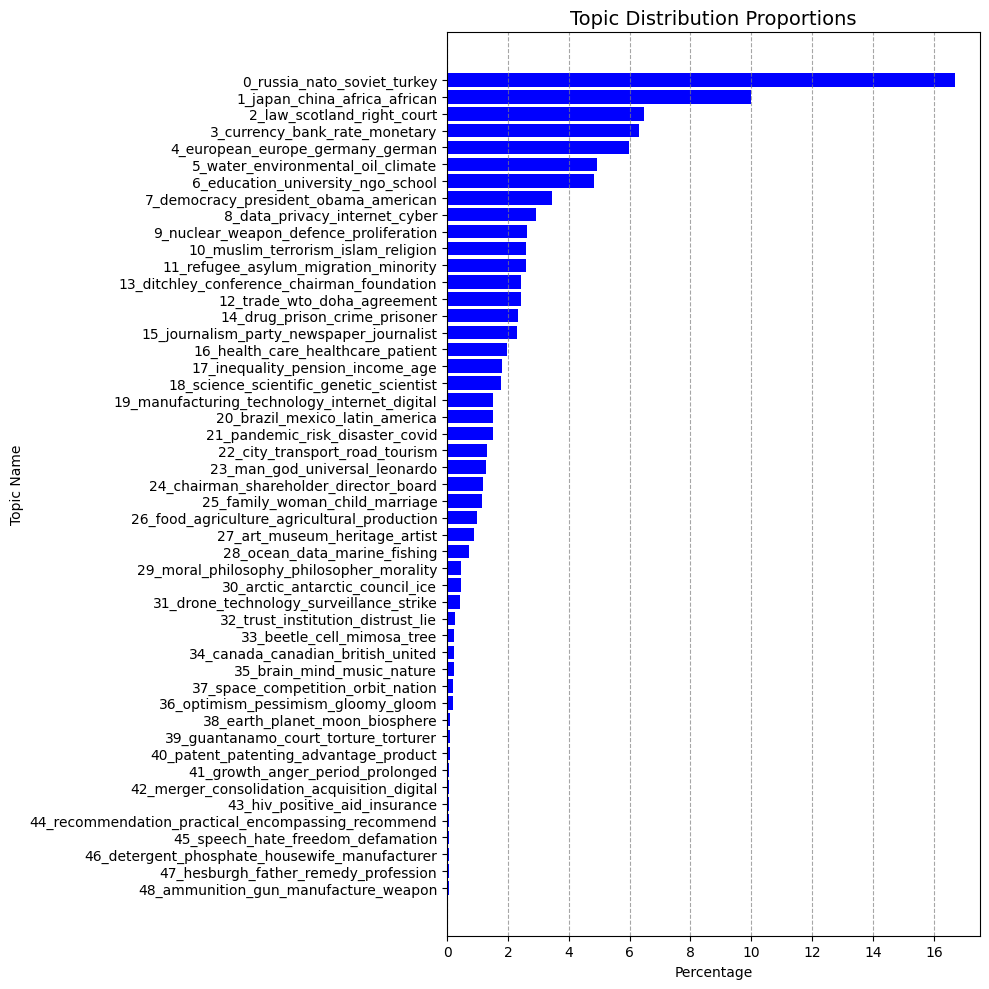

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded your DataFrame, dfcount

# Sort the DataFrame by Proportion in descending order
dfcount_sorted = dfcount.sort_values(by='Proportion', ascending=False)

# Set the figure size (adjust as needed)
plt.figure(figsize=(10, 10))

# Create the bar chart with a grey grid in the background
plt.barh(dfcount_sorted['Name'][::-1], dfcount_sorted['Proportion'][::-1], color='blue')

# Add a grey grid in the background
plt.grid(axis='x', linestyle='--', color='grey', alpha=0.7)

# Set labels and title
plt.xlabel('Percentage')
plt.ylabel('Topic Name')
plt.title('Topic Distribution Proportions', fontsize=14)  # Adjust the title font size as needed

# Adjust the font size of the 'Name' text on the Y-axis
plt.tick_params(axis='y', labelsize=10)  # Adjust the font size as needed

# Show the plot
plt.tight_layout()
plt.show()


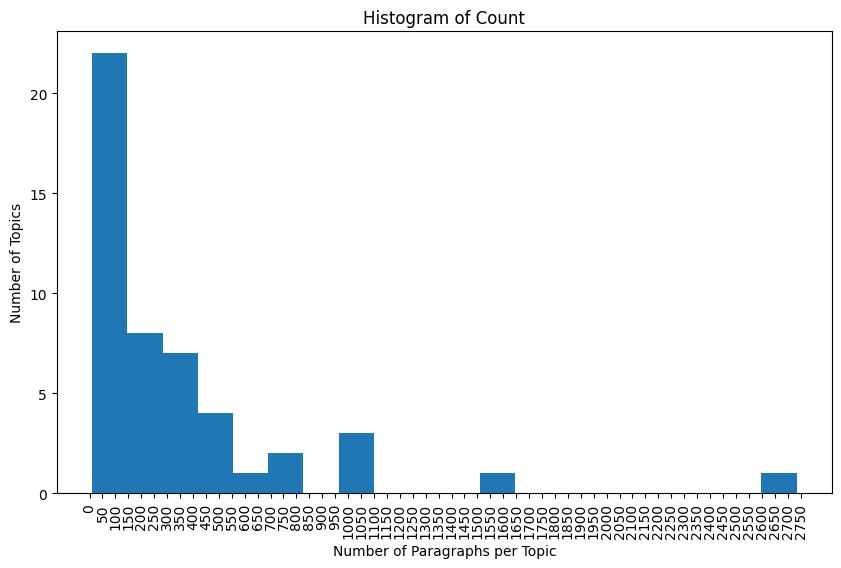

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot a histogram of the 'Count' column
plt.hist(dfcount['Count'], bins=20)  # Adjust the number of bins as needed
plt.xlabel('Number of Paragraphs per Topic')
plt.ylabel('Number of Topics')
plt.title('Histogram of Count')

# Set custom tick marks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
ax.set_xticks(range(0, dfcount['Count'].max() + 50, 50))  # Set tick marks at intervals of 50
plt.xticks(rotation=90)  # Rotate x-axis tick labels if needed

plt.show()


## Get final topic info with time

In [ ]:
#merge topic with date and time

merged_df = filtered_df.merge(df[['para_text_cleaned', 'period', 'year', 'title']], left_on='Document', right_on='para_text_cleaned', how='left')

# Drop the redundant 'para_text_cleaned' column
merged_df.drop('para_text_cleaned', axis=1, inplace=True)


In [ ]:
# Merge the relevant 'para_text' from 'df' into 'merged_df'
merged_df = merged_df.merge(df[['para_text_cleaned', 'para_text']],
                            left_on='Document',
                            right_on='para_text_cleaned',
                            how='left')

# Rename the 'para_text' column to 'Pretext'
merged_df.rename(columns={'para_text': 'Pretext'}, inplace=True)

# Drop the 'para_text_cleaned' column as it's no longer needed
merged_df.drop(columns=['para_text_cleaned'], inplace=True)


In [ ]:
# Count the number of characters in the "Document" column
merged_df['Character_Count'] = merged_df['Document'].apply(lambda x: len(str(x)))

# Count the number of words in the "Document" column
merged_df['Word_Count'] = merged_df['Document'].apply(lambda x: len(str(x).split()))


In [ ]:
# Save Final Topic result
merged_df.to_csv("gdrive/MyDrive/Ditchley001/Finalresult/FinalTopicList.csv", index=False)

## Visualization

Caution! Do not run the code again, as BERT will not be able to re-visualise the model without creating a new instance. Every time the model is run again, there may be minor changes, so it is advisable to use the saved model to maintain consistency.

### Topic Clustering

In [ ]:
model.visualize_topics()

### Topics Over Time

In [ ]:
# Create topics over time
topics_over_time = model.topics_over_time(tweets, timestamps)

59it [00:07,  8.42it/s]


In [ ]:
model.visualize_topics_over_time(topics_over_time, topics=[0, 1, 2, 3, 4, 5, 6,7,8,9,10,11])

In [ ]:
model.visualize_topics_over_time(topics_over_time)

### Topic Word Score

In [ ]:
model.visualize_barchart(topics=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 , 13, 14, 15, 16, 17, 18, 19])


### Topic Heat Map

In [ ]:
model.visualize_heatmap()

### Hierachy

In [ ]:
hierarchical_topics = model.hierarchical_topics(tweets)

In [ ]:
model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
tree = model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─would_could_country_one_also
│    ├─would_could_country_china_europe
│    │    ├─trade_brazil_wto_doha_mexico
│    │    │    ├─■──brazil_mexico_latin_america_brazilian ── Topic: 20
│    │    │    └─■──trade_wto_doha_agreement_round ── Topic: 12
│    │    └─would_could_china_country_europe
│    │         ├─would_could_china_country_europe
│    │         │    ├─■──muslim_terrorism_islam_religion_terrorist ── Topic: 10
│    │         │    └─would_china_could_country_japan
│    │         │         ├─would_china_could_japan_european
│    │         │         │    ├─■──democracy_president_obama_american_democratic ── Topic: 7
│    │         │         │    └─would_china_japan_european_could
│    │         │         │         ├─■──law_scotland_right_court_constitution ── Topic: 2
│    │         │         │         └─china_would_japan_europe_european
│    │         │         │              ├─■──european_europe_germany_german_eurozone ── Topic: 4
│    │         │         │              └─chin

# Topic Distribution Proportion by Period

## Import merged_df data

In [ ]:
## Import data (Shortcut)
merged_df = pd.read_csv("gdrive/MyDrive/Ditchley001/Finalresult/FinalTopicList.csv")

In [ ]:
merged_df

Output hidden; open in https://colab.research.google.com to view.

## Plot graphs

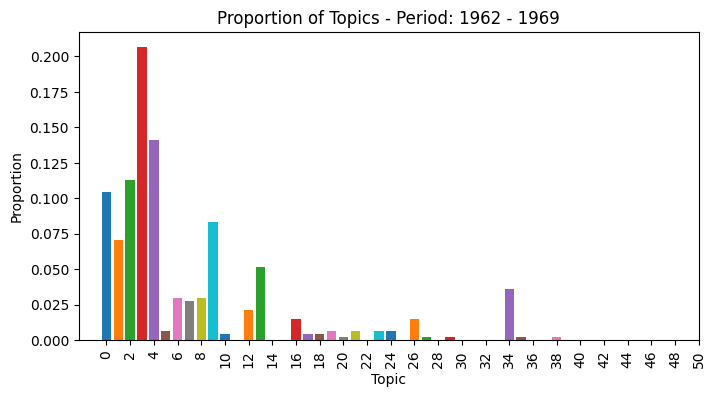

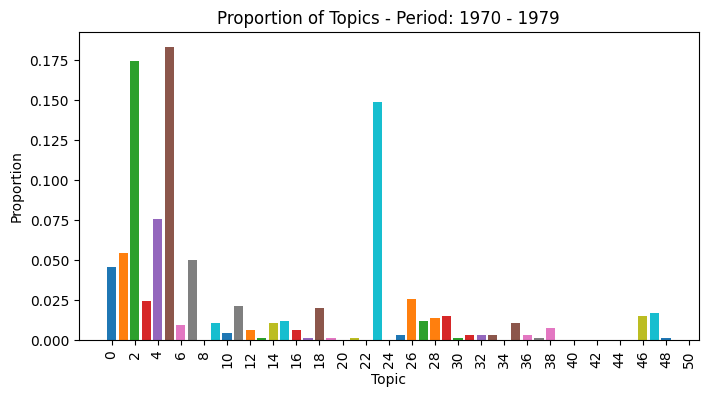

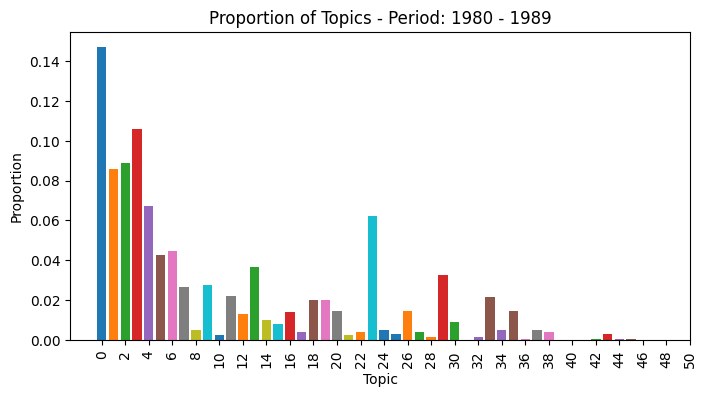

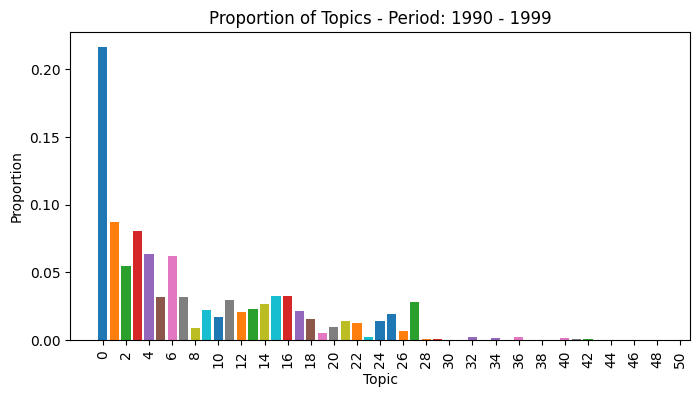

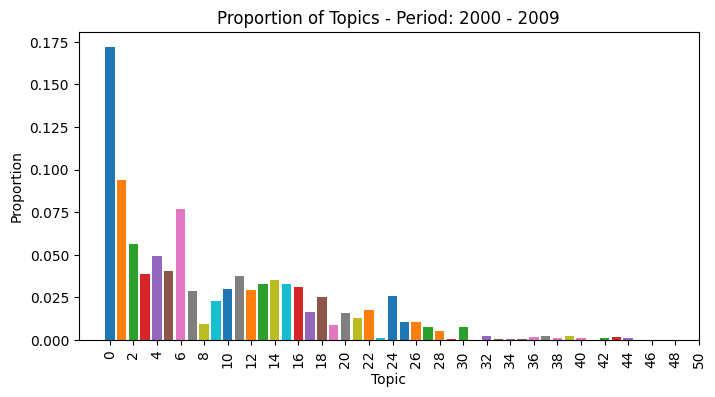

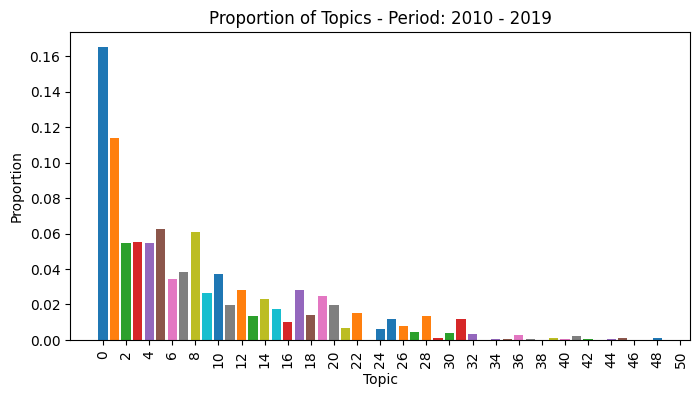

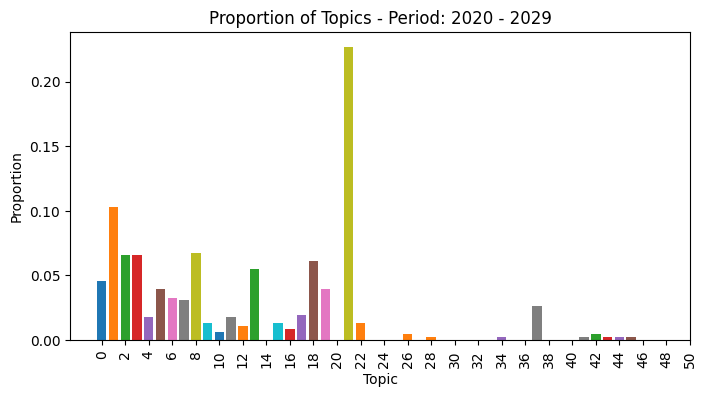

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Group by 'period' and 'Topic' and count occurrences
grouped_df = merged_df.groupby(['period', 'Topic']).size().reset_index(name='count')

# Calculate proportions within each 'period'
grouped_df['proportion'] = grouped_df.groupby('period')['count'].transform(lambda x: x / x.sum())

# Get unique periods
periods = grouped_df['period'].unique()

# Get unique topics
topics = grouped_df['Topic'].unique()

# Generate a list of unique colors for each topic
colors = list(mcolors.TABLEAU_COLORS.values())
color_map = {topic: colors[i % len(colors)] for i, topic in enumerate(topics)}

# Plot separate bar graphs for each period with consistent colors
for period in periods:
    plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
    data = grouped_df[grouped_df['period'] == period]

    # Plot each bar with its corresponding color
    for index, row in data.iterrows():
        plt.bar(row['Topic'], row['proportion'], color=color_map[row['Topic']])

    plt.xlabel('Topic')
    plt.ylabel('Proportion')
    plt.title(f'Proportion of Topics - Period: {period}')
    plt.xticks(rotation=90)

    # Set custom tick marks with even intervals from 0 to 49
    plt.xticks(np.arange(0, 52, 2))

    plt.show()


##Plot Linear graphs

###Overall

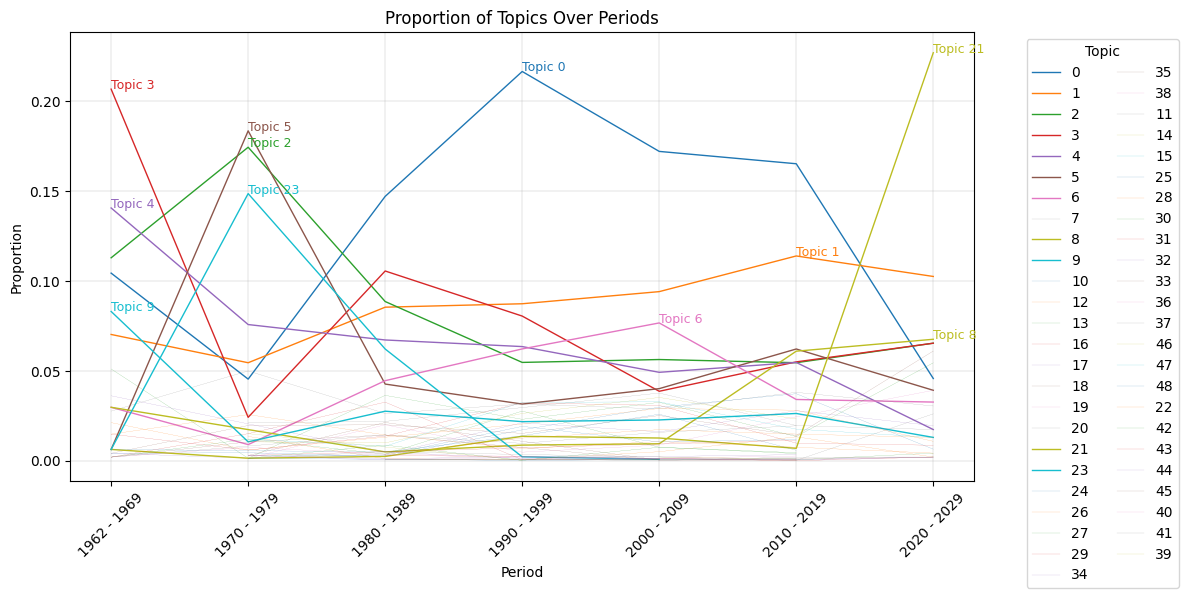

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'period' and 'Topic' and count occurrences
grouped_df = merged_df.groupby(['period', 'Topic']).size().reset_index(name='count')

# Calculate proportions within each 'period'
grouped_df['proportion'] = grouped_df.groupby('period')['count'].transform(lambda x: x / x.sum())

# Get unique periods
periods = grouped_df['period'].unique()

# Get unique topics
topics = grouped_df['Topic'].unique()

# Generate a list of unique colors for each topic
colors = plt.cm.tab10.colors
color_map = {topic: colors[i % len(colors)] for i, topic in enumerate(topics)}

plt.figure(figsize=(12, 6))  # Increase the width to 15

# Define the list of topics to highlight
highlighted_topics = [0, 2, 3, 4, 5, 23, 21, 8, 9, 1, 6]

# Plot lines for all topics with a thinner linewidth
for topic in topics:
    topic_data = grouped_df[grouped_df['Topic'] == topic]
    linewidth = 1 if topic in highlighted_topics else 0.1  # Set linewidth to 0.8 for highlighted topics, otherwise 0.2
    line, = plt.plot(topic_data['period'], topic_data['proportion'], label=topic, color=color_map[topic], linewidth=linewidth)

# Identify and label the overall peak for the top 5 topics in each period
labeled_topics = set()  # To keep track of topics that have been labeled
for period in periods:
    # Get the data for this period
    period_data = grouped_df[grouped_df['period'] == period]

    # Get the top 5 topics for this period
    top_5_topics = period_data.nlargest(5, 'proportion')['Topic']

    # Identify the overall peak for each of the top 5 topics
    for topic in top_5_topics:
        if topic in labeled_topics:
            continue  # Skip if this topic has already been labeled

        # Find the peak proportion for this topic across all periods
        topic_data = grouped_df[grouped_df['Topic'] == topic]
        peak_period = topic_data['proportion'].idxmax()
        peak_proportion = topic_data.loc[peak_period, 'proportion']

        plt.text(topic_data.loc[peak_period, 'period'], peak_proportion, f'Topic {topic}', color=color_map[topic], fontsize=9)
        labeled_topics.add(topic)  # Mark this topic as labeled

plt.xlabel('Period')
plt.ylabel('Proportion')
plt.title('Proportion of Topics Over Periods')

# Add grey grid
plt.grid(color='grey', linestyle='-', linewidth=0.3, alpha=0.5)

# Add legend with 2 columns
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 2 columns for the legend

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###Steady Topics

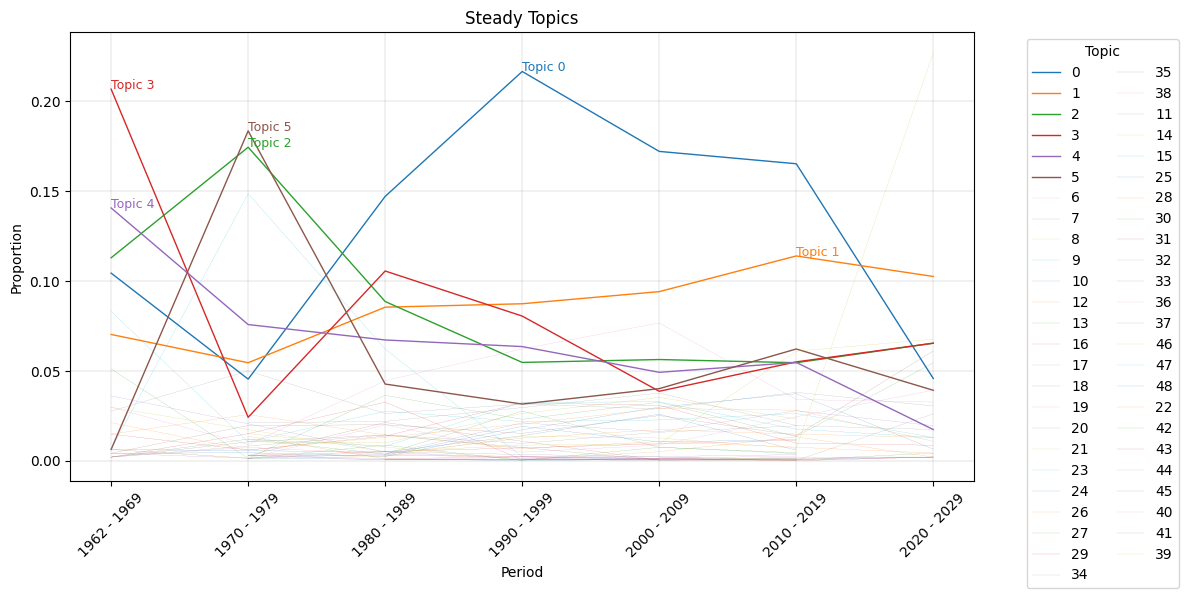

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Your existing code for data preprocessing...
# merged_df = ...

# Group by 'period' and 'Topic' and count occurrences
grouped_df = merged_df.groupby(['period', 'Topic']).size().reset_index(name='count')

# Calculate proportions within each 'period'
grouped_df['proportion'] = grouped_df.groupby('period')['count'].transform(lambda x: x / x.sum())

# Get unique periods
periods = grouped_df['period'].unique()

# Get unique topics
topics = grouped_df['Topic'].unique()

# Generate a list of unique colors for each topic
colors = plt.cm.tab10.colors
color_map = {topic: colors[i % len(colors)] for i, topic in enumerate(topics)}

plt.figure(figsize=(12, 6))  # Increase the width to 15

# Define the list of topics to highlight
highlighted_topics = [0, 1, 2, 3, 4, 5]

# Plot lines for all topics with a thinner linewidth
for topic in topics:
    topic_data = grouped_df[grouped_df['Topic'] == topic]
    linewidth = 1 if topic in highlighted_topics else 0.1  # Set linewidth to 0.8 for highlighted topics, otherwise 0.2
    line, = plt.plot(topic_data['period'], topic_data['proportion'], label=topic, color=color_map[topic], linewidth=linewidth)

# Identify and label the overall peak for the top 5 topics in each period
labeled_topics = set()  # To keep track of topics that have been labeled
for period in periods:
    # Get the data for this period
    period_data = grouped_df[grouped_df['period'] == period]

    # Get the top 5 topics for this period
    top_5_topics = period_data.nlargest(5, 'proportion')['Topic']

    # Identify the overall peak for each of the top 5 topics
    for topic in top_5_topics:
        if topic in labeled_topics or topic not in highlighted_topics:
            continue  # Skip if this topic has already been labeled or not in the highlighted topics

        # Find the peak proportion for this topic across all periods
        topic_data = grouped_df[grouped_df['Topic'] == topic]
        peak_period = topic_data['proportion'].idxmax()
        peak_proportion = topic_data.loc[peak_period, 'proportion']

        plt.text(topic_data.loc[peak_period, 'period'], peak_proportion, f'Topic {topic}', color=color_map[topic], fontsize=9)
        labeled_topics.add(topic)  # Mark this topic as labeled

plt.xlabel('Period')
plt.ylabel('Proportion')
plt.title('Steady Topics')

# Add grey grid
plt.grid(color='grey', linestyle='-', linewidth=0.3, alpha=0.5)

# Add legend with 2 columns
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 2 columns for the legend

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###Emerging Trends

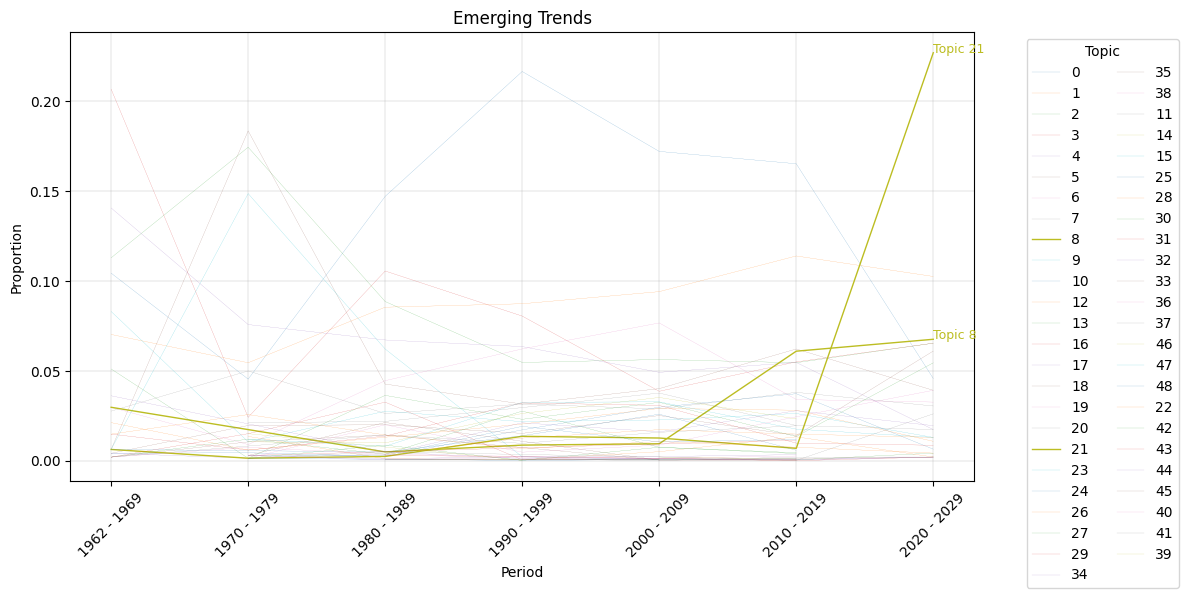

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Your existing code for data preprocessing...
# merged_df = ...

# Group by 'period' and 'Topic' and count occurrences
grouped_df = merged_df.groupby(['period', 'Topic']).size().reset_index(name='count')

# Calculate proportions within each 'period'
grouped_df['proportion'] = grouped_df.groupby('period')['count'].transform(lambda x: x / x.sum())

# Get unique periods
periods = grouped_df['period'].unique()

# Get unique topics
topics = grouped_df['Topic'].unique()

# Generate a list of unique colors for each topic
colors = plt.cm.tab10.colors
color_map = {topic: colors[i % len(colors)] for i, topic in enumerate(topics)}

plt.figure(figsize=(12, 6))  # Increase the width to 15

# Define the list of topics to highlight
highlighted_topics = [8, 21]

# Plot lines for all topics with a thinner linewidth
for topic in topics:
    topic_data = grouped_df[grouped_df['Topic'] == topic]
    linewidth = 1 if topic in highlighted_topics else 0.1  # Set linewidth to 0.8 for highlighted topics, otherwise 0.2
    line, = plt.plot(topic_data['period'], topic_data['proportion'], label=topic, color=color_map[topic], linewidth=linewidth)

# Identify and label the overall peak for the top 5 topics in each period
labeled_topics = set()  # To keep track of topics that have been labeled
for period in periods:
    # Get the data for this period
    period_data = grouped_df[grouped_df['period'] == period]

    # Get the top 5 topics for this period
    top_5_topics = period_data.nlargest(5, 'proportion')['Topic']

    # Identify the overall peak for each of the top 5 topics
    for topic in top_5_topics:
        if topic in labeled_topics or topic not in highlighted_topics:
            continue  # Skip if this topic has already been labeled or not in the highlighted topics

        # Find the peak proportion for this topic across all periods
        topic_data = grouped_df[grouped_df['Topic'] == topic]
        peak_period = topic_data['proportion'].idxmax()
        peak_proportion = topic_data.loc[peak_period, 'proportion']

        plt.text(topic_data.loc[peak_period, 'period'], peak_proportion, f'Topic {topic}', color=color_map[topic], fontsize=9)
        labeled_topics.add(topic)  # Mark this topic as labeled

plt.xlabel('Period')
plt.ylabel('Proportion')
plt.title('Emerging Trends')

# Add grey grid
plt.grid(color='grey', linestyle='-', linewidth=0.3, alpha=0.5)

# Add legend with 2 columns
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 2 columns for the legend

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###Fluctuating Trends

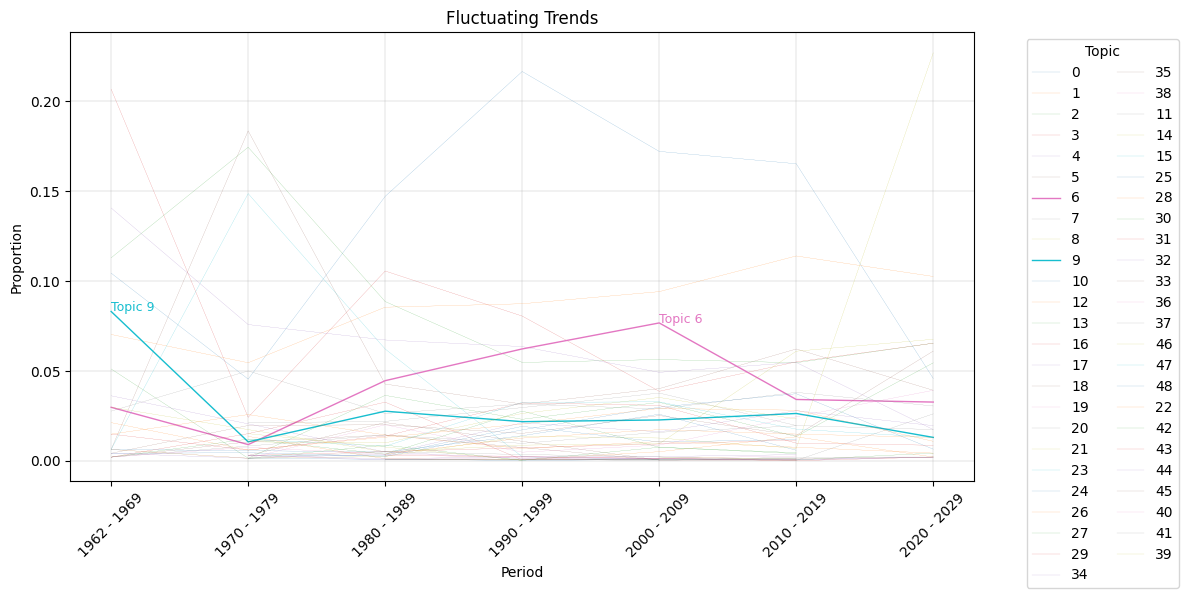

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Your existing code for data preprocessing...
# merged_df = ...

# Group by 'period' and 'Topic' and count occurrences
grouped_df = merged_df.groupby(['period', 'Topic']).size().reset_index(name='count')

# Calculate proportions within each 'period'
grouped_df['proportion'] = grouped_df.groupby('period')['count'].transform(lambda x: x / x.sum())

# Get unique periods
periods = grouped_df['period'].unique()

# Get unique topics
topics = grouped_df['Topic'].unique()

# Generate a list of unique colors for each topic
colors = plt.cm.tab10.colors
color_map = {topic: colors[i % len(colors)] for i, topic in enumerate(topics)}

plt.figure(figsize=(12, 6))  # Increase the width to 15

# Define the list of topics to highlight
highlighted_topics = [6,9]

# Plot lines for all topics with a thinner linewidth
for topic in topics:
    topic_data = grouped_df[grouped_df['Topic'] == topic]
    linewidth = 1 if topic in highlighted_topics else 0.1  # Set linewidth to 0.8 for highlighted topics, otherwise 0.2
    line, = plt.plot(topic_data['period'], topic_data['proportion'], label=topic, color=color_map[topic], linewidth=linewidth)

# Identify and label the overall peak for the top 5 topics in each period
labeled_topics = set()  # To keep track of topics that have been labeled
for period in periods:
    # Get the data for this period
    period_data = grouped_df[grouped_df['period'] == period]

    # Get the top 5 topics for this period
    top_5_topics = period_data.nlargest(5, 'proportion')['Topic']

    # Identify the overall peak for each of the top 5 topics
    for topic in top_5_topics:
        if topic in labeled_topics or topic not in highlighted_topics:
            continue  # Skip if this topic has already been labeled or not in the highlighted topics

        # Find the peak proportion for this topic across all periods
        topic_data = grouped_df[grouped_df['Topic'] == topic]
        peak_period = topic_data['proportion'].idxmax()
        peak_proportion = topic_data.loc[peak_period, 'proportion']

        plt.text(topic_data.loc[peak_period, 'period'], peak_proportion, f'Topic {topic}', color=color_map[topic], fontsize=9)
        labeled_topics.add(topic)  # Mark this topic as labeled

plt.xlabel('Period')
plt.ylabel('Proportion')
plt.title('Fluctuating Trends')

# Add grey grid
plt.grid(color='grey', linestyle='-', linewidth=0.3, alpha=0.5)

# Add legend with 2 columns
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 2 columns for the legend

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###Disappearances

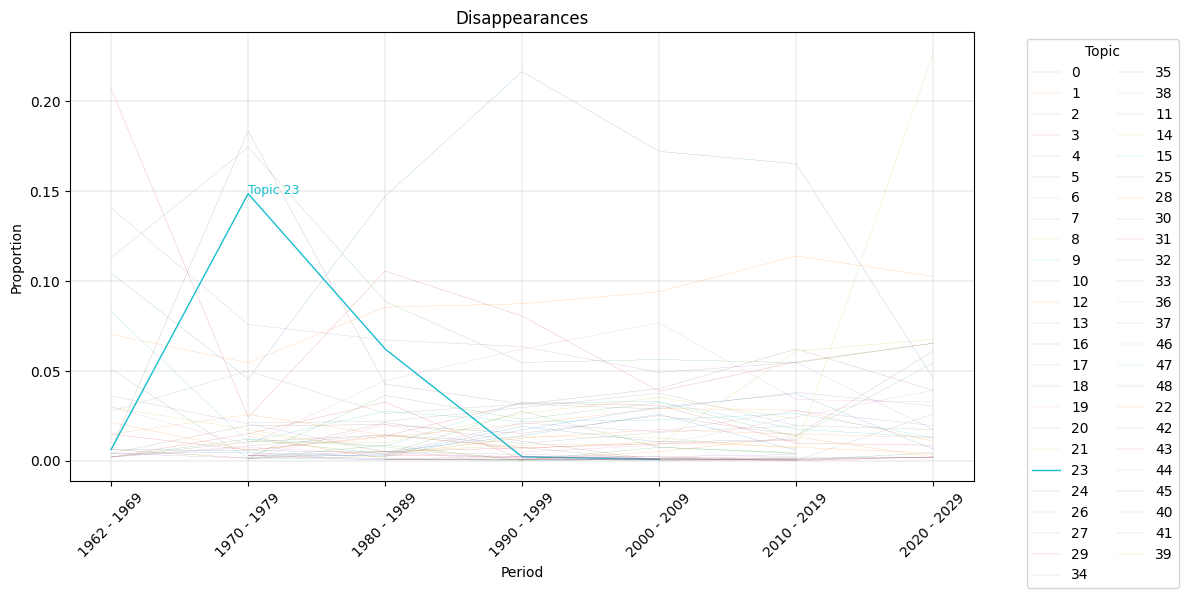

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Your existing code for data preprocessing...
# merged_df = ...

# Group by 'period' and 'Topic' and count occurrences
grouped_df = merged_df.groupby(['period', 'Topic']).size().reset_index(name='count')

# Calculate proportions within each 'period'
grouped_df['proportion'] = grouped_df.groupby('period')['count'].transform(lambda x: x / x.sum())

# Get unique periods
periods = grouped_df['period'].unique()

# Get unique topics
topics = grouped_df['Topic'].unique()

# Generate a list of unique colors for each topic
colors = plt.cm.tab10.colors
color_map = {topic: colors[i % len(colors)] for i, topic in enumerate(topics)}

plt.figure(figsize=(12, 6))  # Increase the width to 15

# Define the list of topics to highlight
highlighted_topics = [23]

# Plot lines for all topics with a thinner linewidth
for topic in topics:
    topic_data = grouped_df[grouped_df['Topic'] == topic]
    linewidth = 1 if topic in highlighted_topics else 0.1  # Set linewidth to 0.8 for highlighted topics, otherwise 0.2
    line, = plt.plot(topic_data['period'], topic_data['proportion'], label=topic, color=color_map[topic], linewidth=linewidth)

# Identify and label the overall peak for the top 5 topics in each period
labeled_topics = set()  # To keep track of topics that have been labeled
for period in periods:
    # Get the data for this period
    period_data = grouped_df[grouped_df['period'] == period]

    # Get the top 5 topics for this period
    top_5_topics = period_data.nlargest(5, 'proportion')['Topic']

    # Identify the overall peak for each of the top 5 topics
    for topic in top_5_topics:
        if topic in labeled_topics or topic not in highlighted_topics:
            continue  # Skip if this topic has already been labeled or not in the highlighted topics

        # Find the peak proportion for this topic across all periods
        topic_data = grouped_df[grouped_df['Topic'] == topic]
        peak_period = topic_data['proportion'].idxmax()
        peak_proportion = topic_data.loc[peak_period, 'proportion']

        plt.text(topic_data.loc[peak_period, 'period'], peak_proportion, f'Topic {topic}', color=color_map[topic], fontsize=9)
        labeled_topics.add(topic)  # Mark this topic as labeled

plt.xlabel('Period')
plt.ylabel('Proportion')
plt.title('Disappearances')

# Add grey grid
plt.grid(color='grey', linestyle='-', linewidth=0.3, alpha=0.5)

# Add legend with 2 columns
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 2 columns for the legend

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Plot by ranking

###Steady Topics

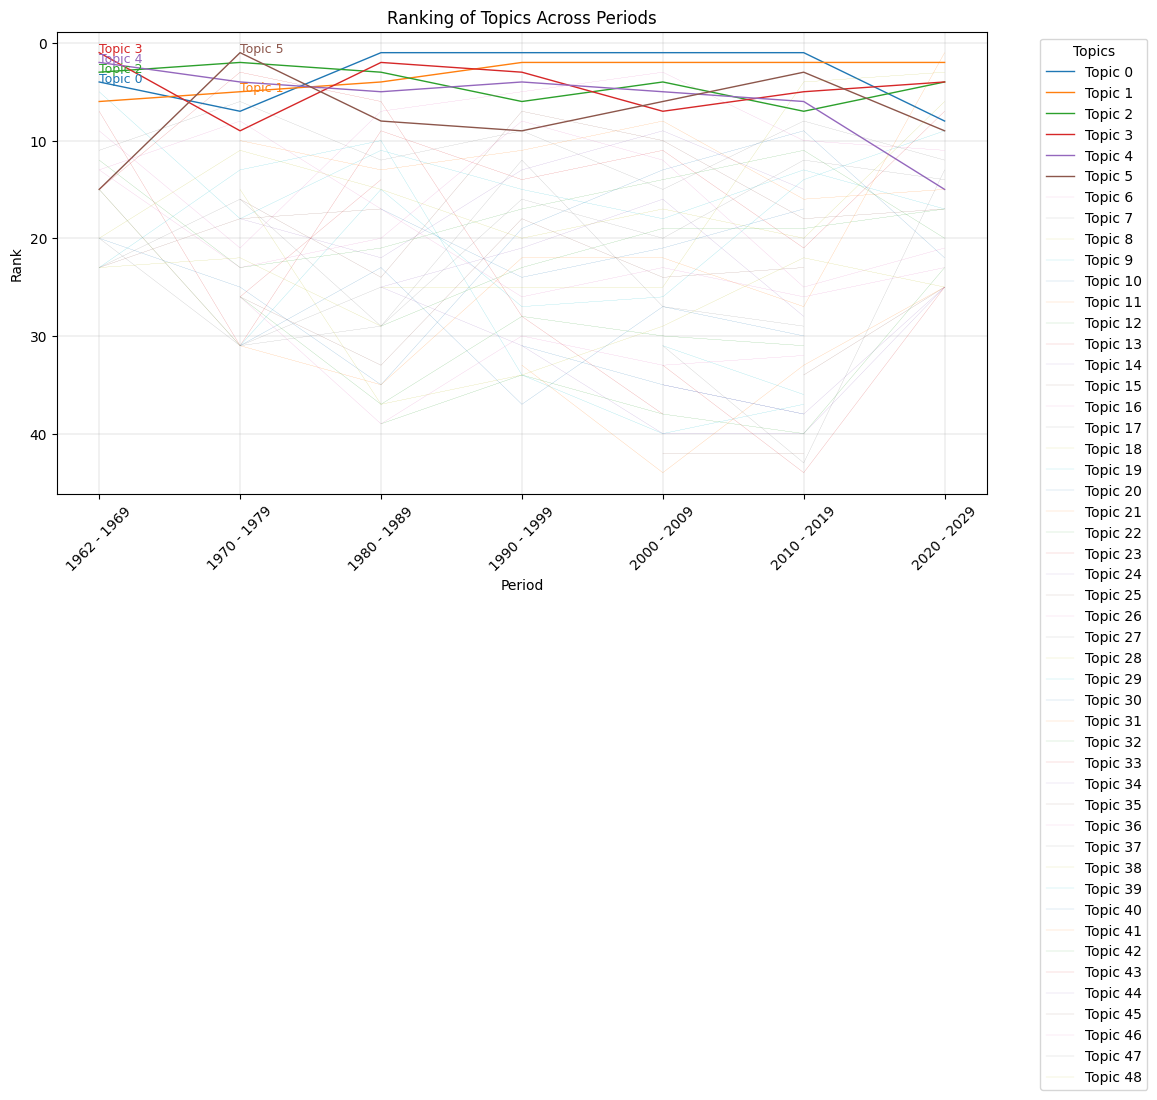

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the merged_df DataFrame

# Calculate the distribution of each topic for each period
topic_distribution = merged_df.groupby(['Topic', 'period']).size().reset_index(name='Distribution')

# Calculate the ranking for each topic within each period
topic_distribution['Rank'] = topic_distribution.groupby('period')['Distribution'].rank(ascending=False, method='min')

# Create a pivot table to reshape the data for plotting
pivot_table = topic_distribution.pivot(index='period', columns='Topic', values='Rank')

# Define the list of topics to highlight
highlighted_topics = [0, 1, 2, 3, 4, 5]

# Plot the data
plt.figure(figsize=(12, 6))
for topic in range(49):
    linewidth = 1 if topic in highlighted_topics else 0.1  # Set linewidth to 0.8 for highlighted topics, otherwise 0.1
    plt.plot(pivot_table.index, pivot_table[topic], label=f"Topic {topic}", linewidth=linewidth)

# Identify and label the overall peak for the top 5 topics in each period
labeled_topics = set()  # To keep track of topics that have been labeled
for period in pivot_table.index:
    # Get the data for this period
    period_data = topic_distribution[topic_distribution['period'] == period]

    # Get the top 5 topics for this period
    top_5_topics = period_data.nlargest(5, 'Distribution')['Topic']

    # Identify the overall peak for each of the topics
    for topic in top_5_topics:
        if topic in labeled_topics or topic not in highlighted_topics:
            continue  # Skip if this topic has already been labeled or not in the highlighted topics

        # Find the peak distribution for this topic across all periods
        topic_data = topic_distribution[topic_distribution['Topic'] == topic]
        peak_period = topic_data['Distribution'].idxmax()
        peak_distribution = topic_data.loc[peak_period, 'Distribution']

        plt.text(period, pivot_table.loc[period, topic], f'Topic {topic}',  color=color_map[topic], fontsize=9)
        labeled_topics.add(topic)  # Mark this topic as labeled


plt.xlabel('Period')
plt.ylabel('Rank')
plt.title('Ranking of Topics Across Periods')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()  # Invert y-axis to have Rank 1 at the top
plt.grid(color='grey', linestyle='-', linewidth=0.3, alpha=0.5)
plt.xticks(rotation=45)
plt.show()


###Fluctuating

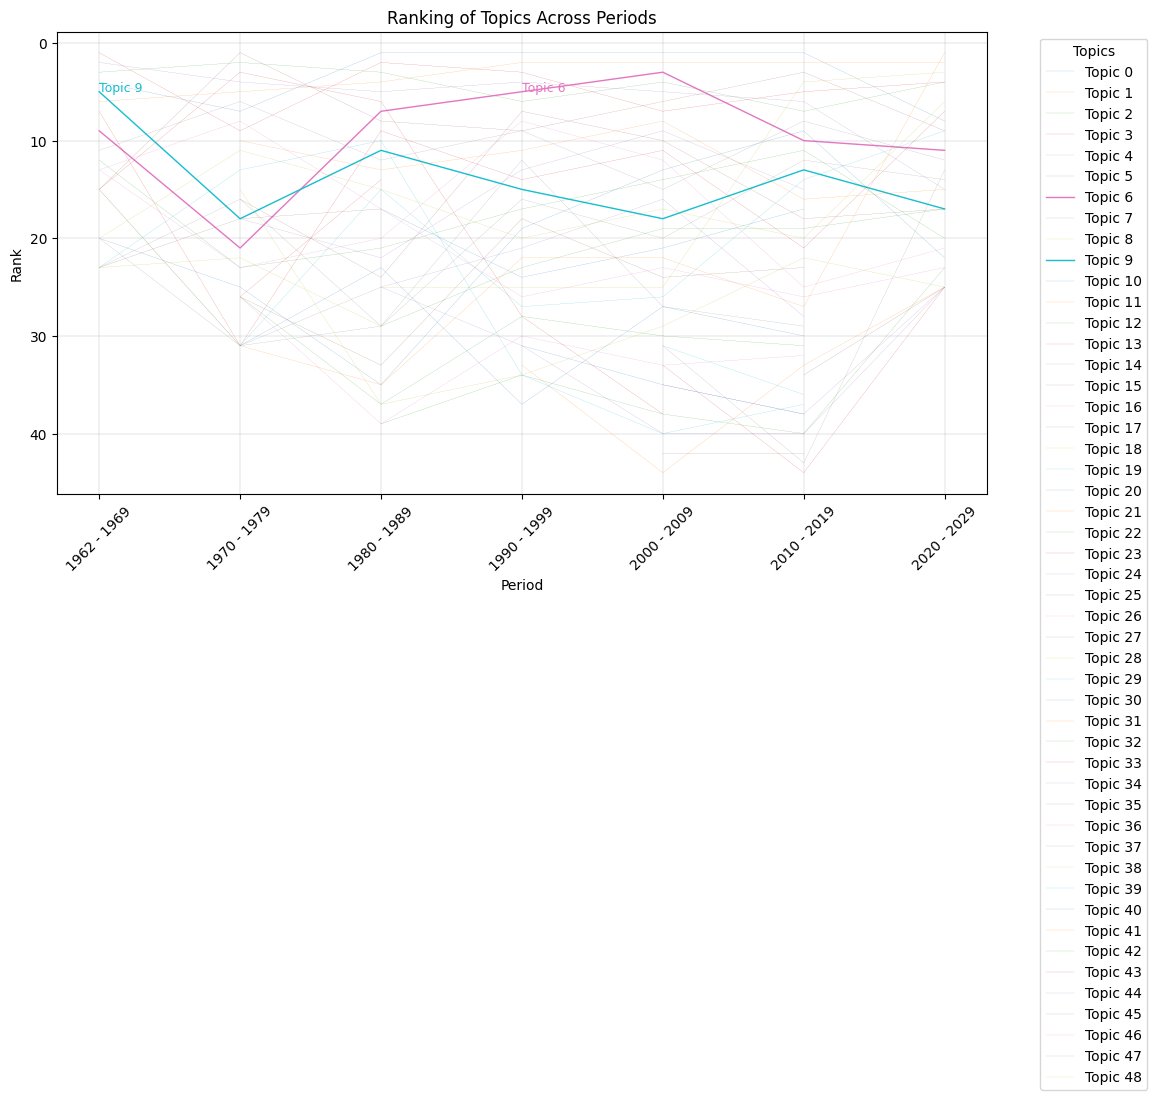

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the merged_df DataFrame

# Calculate the distribution of each topic for each period
topic_distribution = merged_df.groupby(['Topic', 'period']).size().reset_index(name='Distribution')

# Calculate the ranking for each topic within each period
topic_distribution['Rank'] = topic_distribution.groupby('period')['Distribution'].rank(ascending=False, method='min')

# Create a pivot table to reshape the data for plotting
pivot_table = topic_distribution.pivot(index='period', columns='Topic', values='Rank')

# Define the list of topics to highlight
highlighted_topics = [6,9]

# Plot the data
plt.figure(figsize=(12, 6))
for topic in range(49):
    linewidth = 1 if topic in highlighted_topics else 0.1  # Set linewidth to 0.8 for highlighted topics, otherwise 0.1
    plt.plot(pivot_table.index, pivot_table[topic], label=f"Topic {topic}", linewidth=linewidth)

# Identify and label the overall peak for the top 5 topics in each period
labeled_topics = set()  # To keep track of topics that have been labeled
for period in pivot_table.index:
    # Get the data for this period
    period_data = topic_distribution[topic_distribution['period'] == period]

    # Get the top 5 topics for this period
    top_5_topics = period_data.nlargest(5, 'Distribution')['Topic']

    # Identify the overall peak for each of the topics
    for topic in top_5_topics:
        if topic in labeled_topics or topic not in highlighted_topics:
            continue  # Skip if this topic has already been labeled or not in the highlighted topics

        # Find the peak distribution for this topic across all periods
        topic_data = topic_distribution[topic_distribution['Topic'] == topic]
        peak_period = topic_data['Distribution'].idxmax()
        peak_distribution = topic_data.loc[peak_period, 'Distribution']

        plt.text(period, pivot_table.loc[period, topic], f'Topic {topic}',  color=color_map[topic], fontsize=9)
        labeled_topics.add(topic)  # Mark this topic as labeled


plt.xlabel('Period')
plt.ylabel('Rank')
plt.title('Ranking of Topics Across Periods')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()  # Invert y-axis to have Rank 1 at the top
plt.grid(color='grey', linestyle='-', linewidth=0.3, alpha=0.5)
plt.xticks(rotation=45)
plt.show()


###Emerging Trends

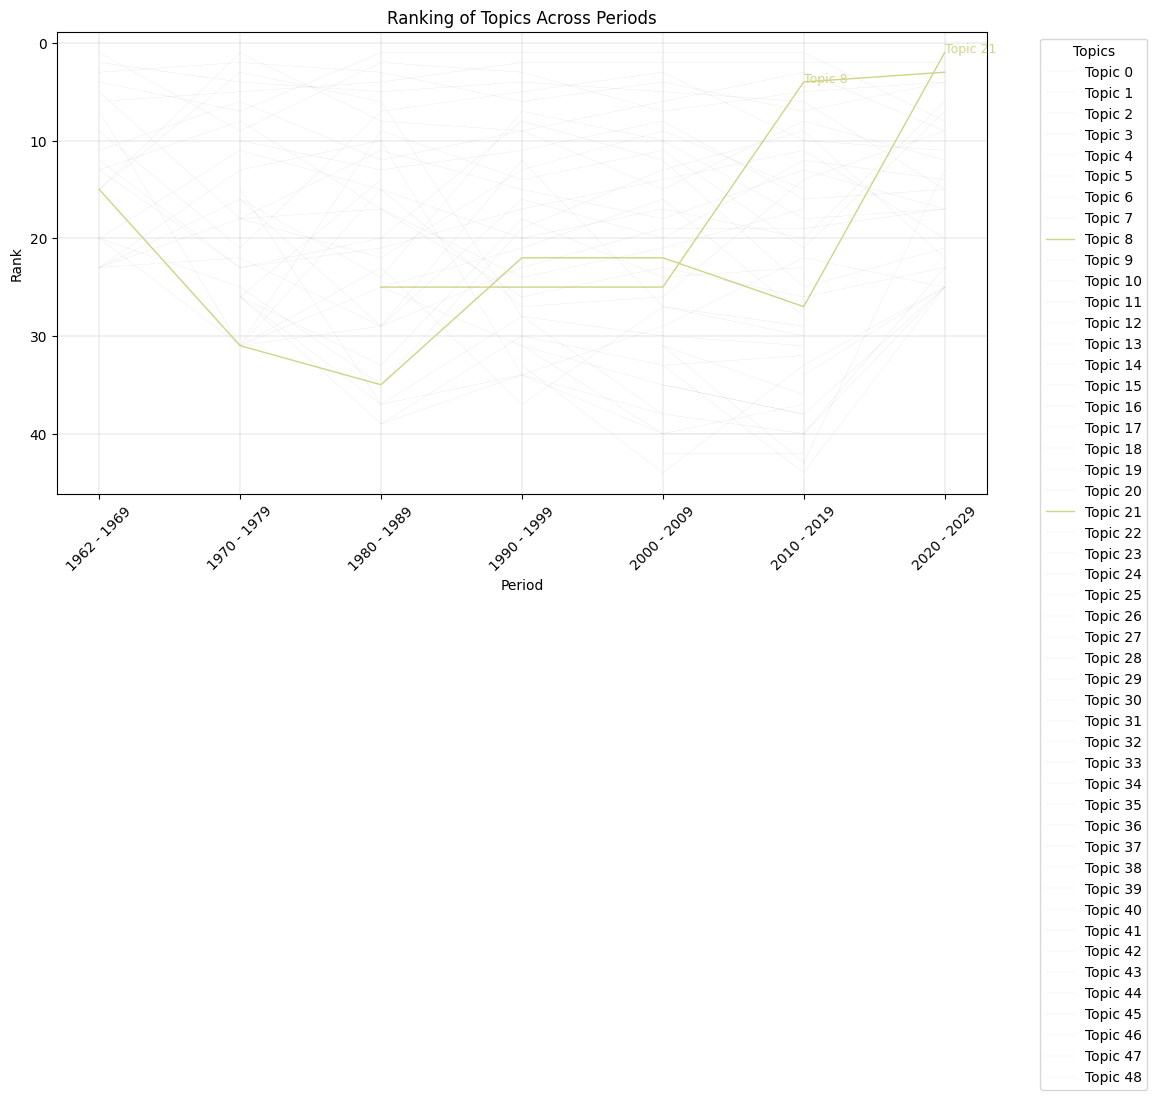

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Calculate the distribution of each topic for each period
topic_distribution = merged_df.groupby(['Topic', 'period']).size().reset_index(name='Distribution')

# Calculate the ranking for each topic within each period
topic_distribution['Rank'] = topic_distribution.groupby('period')['Distribution'].rank(ascending=False, method='min')

# Create a pivot table to reshape the data for plotting
pivot_table = topic_distribution.pivot(index='period', columns='Topic', values='Rank')

# Define the list of topics to highlight
highlighted_topics = [8, 21]

# Define a custom color map
color_map = {8: '#D0D485', 21: '#D0D485'}  # Set the color for Topic 8 and Topic 21 to be the same

# Plot the data
plt.figure(figsize=(12, 6))
for topic in range(49):
    linewidth = 1 if topic in highlighted_topics else 0.05  # Set linewidth to 0.8 for highlighted topics, otherwise 0.1
    color = color_map.get(topic, 'grey')  # Use the custom color if defined, otherwise use 'black'
    plt.plot(pivot_table.index, pivot_table[topic], label=f"Topic {topic}", linewidth=linewidth, color=color)

# Identify and label the overall peak for the top 5 topics in each period
labeled_topics = set()  # To keep track of topics that have been labeled
for period in pivot_table.index:
    # Get the data for this period
    period_data = topic_distribution[topic_distribution['period'] == period]

    # Get the top 5 topics for this period
    top_5_topics = period_data.nlargest(5, 'Distribution')['Topic']

    # Identify the overall peak for each of the topics
    for topic in top_5_topics:
        if topic in labeled_topics or topic not in highlighted_topics:
            continue  # Skip if this topic has already been labeled or not in the highlighted topics

        # Find the peak distribution for this topic across all periods
        topic_data = topic_distribution[topic_distribution['Topic'] == topic]
        peak_period = topic_data['Distribution'].idxmax()
        peak_distribution = topic_data.loc[peak_period, 'Distribution']

        plt.text(period, pivot_table.loc[period, topic], f'Topic {topic}', color=color_map.get(topic, 'black'), fontsize=9)
        labeled_topics.add(topic)  # Mark this topic as labeled

plt.xlabel('Period')
plt.ylabel('Rank')
plt.title('Ranking of Topics Across Periods')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()  # Invert y-axis to have Rank 1 at the top
plt.grid(color='grey', linestyle='-', linewidth=0.3, alpha=0.5)
plt.xticks(rotation=45)
plt.show()


###Disappearances

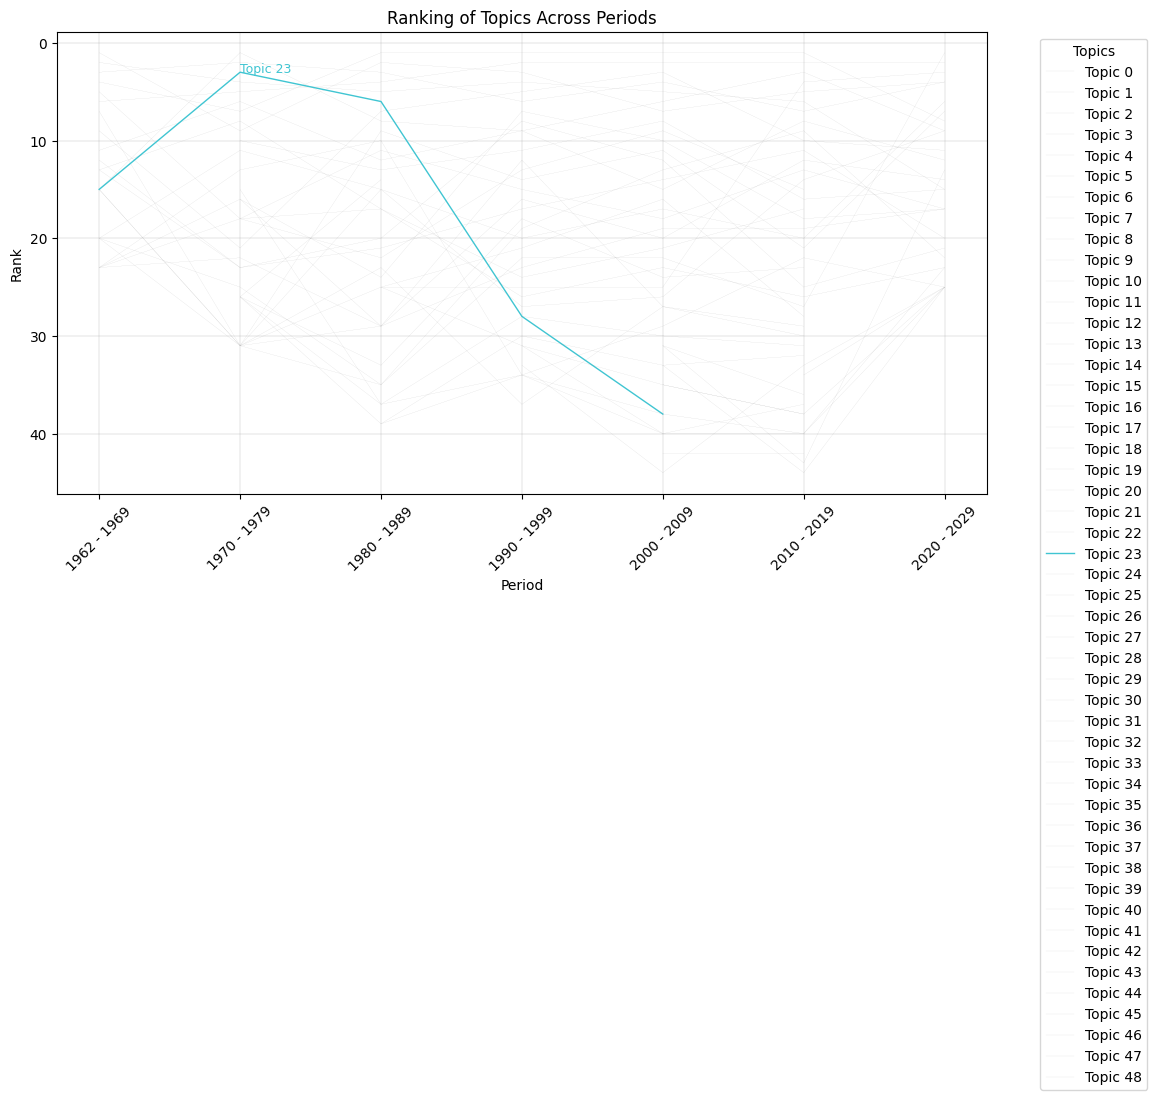

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Calculate the distribution of each topic for each period
topic_distribution = merged_df.groupby(['Topic', 'period']).size().reset_index(name='Distribution')

# Calculate the ranking for each topic within each period
topic_distribution['Rank'] = topic_distribution.groupby('period')['Distribution'].rank(ascending=False, method='min')

# Create a pivot table to reshape the data for plotting
pivot_table = topic_distribution.pivot(index='period', columns='Topic', values='Rank')

# Define the list of topics to highlight
highlighted_topics = [23]

# Define a custom color map
color_map = {23: '#40C5D2'}  # Set the color for Topic 8 and Topic 21 to be the same

# Plot the data
plt.figure(figsize=(12, 6))
for topic in range(49):
    linewidth = 1 if topic in highlighted_topics else 0.05  # Set linewidth to 0.8 for highlighted topics, otherwise 0.1
    color = color_map.get(topic, 'grey')  # Use the custom color if defined, otherwise use 'black'
    plt.plot(pivot_table.index, pivot_table[topic], label=f"Topic {topic}", linewidth=linewidth, color=color)

# Identify and label the overall peak for the top 5 topics in each period
labeled_topics = set()  # To keep track of topics that have been labeled
for period in pivot_table.index:
    # Get the data for this period
    period_data = topic_distribution[topic_distribution['period'] == period]

    # Get the top 5 topics for this period
    top_5_topics = period_data.nlargest(5, 'Distribution')['Topic']

    # Identify the overall peak for each of the topics
    for topic in top_5_topics:
        if topic in labeled_topics or topic not in highlighted_topics:
            continue  # Skip if this topic has already been labeled or not in the highlighted topics

        # Find the peak distribution for this topic across all periods
        topic_data = topic_distribution[topic_distribution['Topic'] == topic]
        peak_period = topic_data['Distribution'].idxmax()
        peak_distribution = topic_data.loc[peak_period, 'Distribution']

        plt.text(period, pivot_table.loc[period, topic], f'Topic {topic}', color=color_map.get(topic, 'black'), fontsize=9)
        labeled_topics.add(topic)  # Mark this topic as labeled

plt.xlabel('Period')
plt.ylabel('Rank')
plt.title('Ranking of Topics Across Periods')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()  # Invert y-axis to have Rank 1 at the top
plt.grid(color='grey', linestyle='-', linewidth=0.3, alpha=0.5)
plt.xticks(rotation=45)
plt.show()


## Get top 5 topics in each period

In [ ]:
import pandas as pd

# Group by 'period' and 'Topic' and count occurrences
grouped_df = merged_df.groupby(['period', 'Name']).size().reset_index(name='count')

# Calculate proportions within each 'period'
grouped_df['proportion'] = grouped_df.groupby('period')['count'].transform(lambda x: x / x.sum())

# Get unique periods
periods = grouped_df['period'].unique()

# Create an empty DataFrame to store the top topics
top_topics_df = pd.DataFrame(columns=['Period', 'Rank', 'Name', 'Proportion'])  # Add 'Proportion' to the columns

# Iterate over each period
for period in periods:
    data = grouped_df[grouped_df['period'] == period]
    topics = data['Name'].tolist()
    proportions = data['proportion'].tolist()

    # Sort proportions in descending order and select the top 5 topics
    sorted_indices = sorted(range(len(proportions)), key=lambda i: proportions[i], reverse=True)[:5]
    sorted_topics = [topics[i] for i in sorted_indices]
    sorted_proportions = [round(proportions[i], 2) for i in sorted_indices]  # Round to 2 decimal places here

    # Create a DataFrame with the top topics and their proportions
    top_topics_period_df = pd.DataFrame({
        'Period': [period] * len(sorted_topics),
        'Rank': range(1, len(sorted_topics) + 1),
        'Name': sorted_topics,
        'Proportion': sorted_proportions  # Use the rounded proportions
    })

    # Append the top topics of the period to the overall DataFrame
    top_topics_df = top_topics_df.append(top_topics_period_df, ignore_index=True)


# Display the resulting table
top_topics_df


Period Rank                                    Name  Proportion
0   1962 - 1969    1           3_currency_bank_rate_monetary        0.21
1   1962 - 1969    2        4_european_europe_germany_german        0.14
2   1962 - 1969    3              2_law_scotland_right_court        0.11
3   1962 - 1969    4             0_russia_nato_soviet_turkey        0.10
4   1962 - 1969    5  9_nuclear_weapon_defence_proliferation        0.08
5   1970 - 1979    1       5_water_environmental_oil_climate        0.18
6   1970 - 1979    2              2_law_scotland_right_court        0.17
7   1970 - 1979    3           23_man_god_universal_leonardo        0.15
8   1970 - 1979    4        4_european_europe_germany_german        0.08
9   1970 - 1979    5            1_japan_china_africa_african        0.05
10  1980 - 1989    1             0_russia_nato_soviet_turkey        0.15
11  1980 - 1989    2           3_currency_bank_rate_monetary        0.11
12  1980 - 1989    3              2_law_scotland_right_court        0.09
13  1980 - 1989    4            1_japan_china_africa_african        0.09
14  1980 - 1989    5        4_european_europe_germany_german        0.07
15  1990 - 1999    1             0_russia_nato_soviet_turkey        0.22
16  1990 - 1999    2            1_japan_china_africa_african        0.09
17  1990 - 1999    3           3_currency_bank_rate_monetary        0.08
18  1990 - 1999    4        4_european_europe_germany_german        0.06
19  1990 - 1999    5       6_education_university_ngo_school        0.06
20  2000 - 2009    1             0_russia_nato_soviet_turkey        0.17
21  2000 - 2009    2            1_japan_china_africa_african        0.09
22  2000 - 2009    3       6_education_university_ngo_school        0.08
23  2000 - 2009    4              2_law_scotland_right_court        0.06
24  2000 - 2009    5        4_european_europe_germany_german        0.05
25  2010 - 2019    1             0_russia_nato_soviet_turkey        0.17
26  2010 - 2019    2            1_japan_china_africa_african        0.11
27  2010 - 2019    3       5_water_environmental_oil_climate        0.06
28  2010 - 2019    4           8_data_privacy_internet_cyber        0.06
29  2010 - 2019    5           3_currency_bank_rate_monetary        0.06
30  2020 - 2029    1         21_pandemic_risk_disaster_covid        0.23
31  2020 - 2029    2            1_japan_china_africa_african        0.10
32  2020 - 2029    3           8_data_privacy_internet_cyber        0.07
33  2020 - 2029    4              2_law_scotland_right_court        0.07
34  2020 - 2029    5           3_currency_bank_rate_monetary        0.07

##Get top 10 topics in each period

In [ ]:
import pandas as pd

# Group by 'period' and 'Topic' and count occurrences
grouped_df = merged_df.groupby(['period', 'Name']).size().reset_index(name='count')

# Calculate proportions within each 'period'
grouped_df['proportion'] = grouped_df.groupby('period')['count'].transform(lambda x: x / x.sum())

# Get unique periods
periods = grouped_df['period'].unique()

# Create an empty DataFrame to store the top topics
top_topics_df = pd.DataFrame(columns=['Period', 'Rank', 'Name', 'Proportion'])  # Add 'Proportion' to the columns

# Iterate over each period
for period in periods:
    data = grouped_df[grouped_df['period'] == period]
    topics = data['Name'].tolist()
    proportions = data['proportion'].tolist()

    # Sort proportions in descending order and select the top 10 topics
    sorted_indices = sorted(range(len(proportions)), key=lambda i: proportions[i], reverse=True)[:10]
    sorted_topics = [topics[i] for i in sorted_indices]
    sorted_proportions = [round(proportions[i], 2) for i in sorted_indices]  # Round to 2 decimal places here

    # Create a DataFrame with the top topics and their proportions
    top_topics_period_df = pd.DataFrame({
        'Period': [period] * len(sorted_topics),
        'Rank': range(1, len(sorted_topics) + 1),
        'Name': sorted_topics,
        'Proportion': sorted_proportions  # Use the rounded proportions
    })

    # Append the top topics of the period to the overall DataFrame
    top_topics_df = top_topics_df.append(top_topics_period_df, ignore_index=True)


# Display the resulting table
top_topics_df


##Get all topic proportion by period

In [ ]:
import pandas as pd

# Assuming merged_df is defined and includes 'Topic'

# Group by 'period', 'Name', and 'Topic' and count occurrences
grouped_df = merged_df.groupby(['period', 'Name', 'Topic']).size().reset_index(name='count')

# Calculate proportions within each 'period'
grouped_df['proportion'] = grouped_df.groupby('period')['count'].transform(lambda x: x / x.sum())

# Get unique periods
periods = grouped_df['period'].unique()

# Create an empty DataFrame to store the top topics
top_topics_df = pd.DataFrame(columns=['Period', 'Rank', 'Name', 'Proportion', 'Topic'])  # Add 'Topic' to the columns

# Iterate over each period
for period in periods:
    data = grouped_df[grouped_df['period'] == period]
    topics = data['Name'].tolist()
    proportions = data['proportion'].tolist()
    topic_column = data['Topic'].tolist()  # Extract 'Topic' information

    # Sort proportions in descending order and select the top 5 topics
    sorted_indices = sorted(range(len(proportions)), key=lambda i: proportions[i], reverse=True)[:5]
    sorted_topics = [topics[i] for i in sorted_indices]
    sorted_proportions = [round(proportions[i], 2) for i in sorted_indices]  # Round to 2 decimal places here
    sorted_topic_column = [topic_column[i] for i in sorted_indices]  # Get the sorted 'Topic' information

    # Create a DataFrame with the top topics and their proportions
    top_topics_period_df = pd.DataFrame({
        'Period': [period] * len(sorted_topics),
        'Rank': range(1, len(sorted_topics) + 1),
        'Name': sorted_topics,
        'Proportion': sorted_proportions,  # Use the rounded proportions
        'Topic': sorted_topic_column  # Add the 'Topic' information
    })

    # Append the top topics of the period to the overall DataFrame
    top_topics_df = top_topics_df.append(top_topics_period_df, ignore_index=True)

# Display the resulting table
top_topics_df


Period Rank                                    Name  Proportion Topic
0   1962 - 1969    1           3_currency_bank_rate_monetary        0.21     3
1   1962 - 1969    2        4_european_europe_germany_german        0.14     4
2   1962 - 1969    3              2_law_scotland_right_court        0.11     2
3   1962 - 1969    4             0_russia_nato_soviet_turkey        0.10     0
4   1962 - 1969    5  9_nuclear_weapon_defence_proliferation        0.08     9
5   1970 - 1979    1       5_water_environmental_oil_climate        0.18     5
6   1970 - 1979    2              2_law_scotland_right_court        0.17     2
7   1970 - 1979    3           23_man_god_universal_leonardo        0.15    23
8   1970 - 1979    4        4_european_europe_germany_german        0.08     4
9   1970 - 1979    5            1_japan_china_africa_african        0.05     1
10  1980 - 1989    1             0_russia_nato_soviet_turkey        0.15     0
11  1980 - 1989    2           3_currency_bank_rate_monetary        0.11     3
12  1980 - 1989    3              2_law_scotland_right_court        0.09     2
13  1980 - 1989    4            1_japan_china_africa_african        0.09     1
14  1980 - 1989    5        4_european_europe_germany_german        0.07     4
15  1990 - 1999    1             0_russia_nato_soviet_turkey        0.22     0
16  1990 - 1999    2            1_japan_china_africa_african        0.09     1
17  1990 - 1999    3           3_currency_bank_rate_monetary        0.08     3
18  1990 - 1999    4        4_european_europe_germany_german        0.06     4
19  1990 - 1999    5       6_education_university_ngo_school        0.06     6
20  2000 - 2009    1             0_russia_nato_soviet_turkey        0.17     0
21  2000 - 2009    2            1_japan_china_africa_african        0.09     1
22  2000 - 2009    3       6_education_university_ngo_school        0.08     6
23  2000 - 2009    4              2_law_scotland_right_court        0.06     2
24  2000 - 2009    5        4_european_europe_germany_german        0.05     4
25  2010 - 2019    1             0_russia_nato_soviet_turkey        0.17     0
26  2010 - 2019    2            1_japan_china_africa_african        0.11     1
27  2010 - 2019    3       5_water_environmental_oil_climate        0.06     5
28  2010 - 2019    4           8_data_privacy_internet_cyber        0.06     8
29  2010 - 2019    5           3_currency_bank_rate_monetary        0.06     3
30  2020 - 2029    1         21_pandemic_risk_disaster_covid        0.23    21
31  2020 - 2029    2            1_japan_china_africa_african        0.10     1
32  2020 - 2029    3           8_data_privacy_internet_cyber        0.07     8
33  2020 - 2029    4              2_law_scotland_right_court        0.07     2
34  2020 - 2029    5           3_currency_bank_rate_monetary        0.07     3

#Summarise Intertopic Distance map

In [ ]:
import pandas as pd

# Define the clusters
clusters = {
    'Cluster A': [0,1,3,4,9,10,12,13,20,24,32,34,41,42,45,48],
    'Cluster B': [2,7,11,15,23,27,29,33,35,38,39,47],
    'Cluster C': [6,14,16,18,21,36,40,43,44,46],
    'Cluster D': [5,22,26,28,30,37],
    'Cluster E': [8,19,31],
    'Cluster F': [17, 25],
}

# Assign clusters to topics
def assign_cluster(topic):
    for cluster, topics in clusters.items():
        if topic in topics:
            return cluster
    return None

merged_df['Cluster'] = merged_df['Topic'].apply(assign_cluster)

# Group by Cluster and Topic, and count the rows
intertopic = merged_df.groupby(['Cluster', 'Topic']).agg(
    Name=('Name', 'first'),
    Representation=('Representation', 'first'),
    Count=('Topic', 'size')
).reset_index()

# Rename the columns as required
intertopic.columns = ['Cluster', 'Topic', 'Name', 'Representation', 'Count']




In [ ]:
# Resulting DataFrame is stored in 'intertopic'
intertopic

Cluster  Topic                                               Name  \
0   Cluster A      0                        0_russia_nato_soviet_turkey   
1   Cluster A      1                       1_japan_china_africa_african   
2   Cluster A      3                      3_currency_bank_rate_monetary   
3   Cluster A      4                   4_european_europe_germany_german   
4   Cluster A      9             9_nuclear_weapon_defence_proliferation   
5   Cluster A     10                 10_muslim_terrorism_islam_religion   
6   Cluster A     12                        12_trade_wto_doha_agreement   
7   Cluster A     13         13_ditchley_conference_chairman_foundation   
8   Cluster A     20                     20_brazil_mexico_latin_america   
9   Cluster A     24             24_chairman_shareholder_director_board   
10  Cluster A     32                  32_trust_institution_distrust_lie   
11  Cluster A     34                  34_canada_canadian_british_united   
12  Cluster A     41                   41_growth_anger_period_prolonged   
13  Cluster A     42        42_merger_consolidation_acquisition_digital   
14  Cluster A     45                  45_speech_hate_freedom_defamation   
15  Cluster A     48               48_ammunition_gun_manufacture_weapon   
16  Cluster B      2                         2_law_scotland_right_court   
17  Cluster B      7               7_democracy_president_obama_american   
18  Cluster B     11               11_refugee_asylum_migration_minority   
19  Cluster B     15           15_journalism_party_newspaper_journalist   
20  Cluster B     23                      23_man_god_universal_leonardo   
21  Cluster B     27                      27_art_museum_heritage_artist   
22  Cluster B     29           29_moral_philosophy_philosopher_morality   
23  Cluster B     33                         33_beetle_cell_mimosa_tree   
24  Cluster B     35                         35_brain_mind_music_nature   
25  Cluster B     38                     38_earth_planet_moon_biosphere   
26  Cluster B     39               39_guantanamo_court_torture_torturer   
27  Cluster B     47               47_hesburgh_father_remedy_profession   
28  Cluster C      6                  6_education_university_ngo_school   
29  Cluster C     14                      14_drug_prison_crime_prisoner   
30  Cluster C     16                  16_health_care_healthcare_patient   
31  Cluster C     18            18_science_scientific_genetic_scientist   
32  Cluster C     21                    21_pandemic_risk_disaster_covid   
33  Cluster C     36                 36_optimism_pessimism_gloomy_gloom   
34  Cluster C     40              40_patent_patenting_advantage_product   
35  Cluster C     43                      43_hiv_positive_aid_insurance   
36  Cluster C     44  44_recommendation_practical_encompassing_recom...   
37  Cluster C     46      46_detergent_phosphate_housewife_manufacturer   
38  Cluster D      5                  5_water_environmental_oil_climate   
39  Cluster D     22                     22_city_transport_road_tourism   
40  Cluster D     26        26_food_agriculture_agricultural_production   
41  Cluster D     28                       28_ocean_data_marine_fishing   
42  Cluster D     30                    30_arctic_antarctic_council_ice   
43  Cluster D     37                  37_space_competition_orbit_nation   
44  Cluster E      8                      8_data_privacy_internet_cyber   
45  Cluster E     19       19_manufacturing_technology_internet_digital   
46  Cluster E     31            31_drone_technology_surveillance_strike   
47  Cluster F     17                   17_inequality_pension_income_age   
48  Cluster F     25                     25_family_woman_child_marriage   

                                       Representation  Count  
0   ['russia', 'nato', 'soviet', 'turkey', 'would'...   2783  
1   ['japan', 'china', 'africa', 'african', 'chine...   1651  
2   ['currency', 'bank', 'rate', 'monetary', 'rese...   1077  
3  

In [ ]:
# Save Final Topic result
intertopic.to_csv("gdrive/MyDrive/Ditchley001/Finalresult/Finalintertopic.csv", index=False)

#Conference Analysis

In [ ]:
import pandas as pd

# Assuming merged_df is already defined

# List of all topics
topics = ['Topic ' + str(i) for i in range(49)]

# Create a new DataFrame with the required columns
conferencetopic = merged_df[['period', 'year', 'title']].drop_duplicates()

# Set all topics to 0 initially
for topic in topics:
    conferencetopic[topic] = 0

# Calculate the proportion of each topic for each title
for title, group in merged_df.groupby('title'):
    topic_counts = group['Topic'].value_counts(normalize=True)
    for topic, count in topic_counts.iteritems():
        conferencetopic.loc[conferencetopic['title'] == title, 'Topic ' + str(topic)] = count

# Verify that the proportions sum to 1 for each title
for index, row in conferencetopic.iterrows():
    assert abs(sum(row[topics]) - 1) < 1e-6, "Proportions don't sum to 1 for title: " + row['title']


In [ ]:
conferencetopic

period  year                                              title  \
0      2020 - 2029  2022              Ditchley Regional Devolution Briefing   
3      2020 - 2029  2022  Ditchley Foundation Annual Lecture LVIII After...   
5      2020 - 2029  2021  Space: the new space race and its intersection...   
23     2020 - 2029  2021  Climate judo: how can the impact of the pandem...   
35     2020 - 2029  2021  Europe and the UK: building a new partnership ...   
...            ...   ...                                                ...   
16760  1962 - 1969  1963              Ditchley Foundation Annual Lecture II   
16804  1962 - 1969  1963  The problem of the nuclear deterrent in the co...   
16815  1962 - 1969  1962               Ditchley Foundation Annual Lecture I   
16831  1962 - 1969  1962   British and American policies in tropical Africa   
16852  1962 - 1969  1962  The impact of European integration on Commonwe...   

        Topic 0   Topic 1   Topic 2   Topic 3   Topic 4   Topic 5  Topic 6  \
0      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
3      0.500000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
5      0.055556  0.000000  0.000000  0.000000  0.000000  0.055556  0.00000   
23     0.000000  0.000000  0.000000  0.083333  0.000000  0.333333  0.00000   
35     0.222222  0.111111  0.000000  0.000000  0.222222  0.111111  0.00000   
...         ...       ...       ...       ...       ...       ...      ...   
16760  0.295455  0.000000  0.000000  0.000000  0.181818  0.000000  0.00000   
16804  0.181818  0.000000  0.090909  0.000000  0.000000  0.000000  0.00000   
16815  0.000000  0.000000  0.062500  0.000000  0.125000  0.000000  0.00000   
16831  0.047619  0.285714  0.000000  0.000000  0.000000  0.000000  0.52381   
16852  0.000000  0.058824  0.058824  0.000000  0.117647  0.000000  0.00000   

       ...  Topic 39  Topic 40  Topic 41  Topic 42  Topic 43  Topic 44  \
0      ...       0.0       0.0       0.0       0.0       0.0  0.333333   
3      ...       0.0       0.0       0.0       0.0       0.0  0.000000   
5      ...       0.0       0.0       0.0       0.0       0.0  0.000000   
23     ...       0.0       0.0       0.0       0.0       0.0  0.000000   
35     ...       0.0       0.0       0.0       0.0       0.0  0.000000   
...    ...       ...       ...       ...       ...       ...       ...   
16760  ...       0.0       0.0       0.0       0.0       0.0  0.000000   
16804  ...       0.0       0.0       0.0       0.0       0.0  0.000000   
16815  ...       0.0       0.0       0.0       0.0       0.0  0.000000   
16831  ...       0.0       0.0       0.0       0.0       0.0  0.000000   
16852  ...       0.0       0.0       0.0       0.0       0.0  0.000000   

       Topic 45  Topic 46  Topic 47  Topic 48  
0           0.0       0.0       0.0       0.0  
3           0.0       0.0       0.0       0.0  
5           0.0       0.0       0.0       0.0  
23          0.0       0.0       0.0       0.0  
35          0.0       0.0       0.0       0.0  
...         ...       ...       ...       ...  
16760       0.0       0.0       0.0       0.0  
16804       0.0       0.0       0.0       0.0  
16815       0.0       0.0       0.0       0.0  
16831       0.0       0.0       0.0       0.0  
16852       0.0       0.0       0.0       0.0  

[510 rows x 52 columns]

In [ ]:
# Save Final Topic result
conferencetopic.to_csv("gdrive/MyDrive/Ditchley001/Finalresult/conferencetopic01.csv", index=False)

##Find topic 1,2,3 average distribution

In [ ]:
## Import data (Shortcut)
conferencetopic = pd.read_csv("gdrive/MyDrive/Ditchley001/Finalresult/conferencetopic01.csv")

In [ ]:
conferencetopic

###Check average distribution of Top 1 - 3 Topics

In [ ]:
# Define functions to get the values of the top 1, top 2, and top 3 topics for a row
def top_1_value(row):
    return row.nlargest(1).values[0]

def top_2_value(row):
    return row.nlargest(2).values[-1]

def top_3_value(row):
    return row.nlargest(3).values[-1]

# Apply these functions to each row of the topics in conferencetopic to get the values of the top 1, top 2, and top 3 topics for each title
top_1_values_per_title = conferencetopic[topics].apply(top_1_value, axis=1)
top_2_values_per_title = conferencetopic[topics].apply(top_2_value, axis=1)
top_3_values_per_title = conferencetopic[topics].apply(top_3_value, axis=1)

# Calculate the averages of the top 1, top 2, and top 3 topics
average_top_1_topic = top_1_values_per_title.mean()
average_top_2_topic = top_2_values_per_title.mean()
average_top_3_topic = top_3_values_per_title.mean()

print("Average distribution of top 1 (1st rank) topic per title:", average_top_1_topic)
print("Average distribution of top 2 (2nd rank) topic per title:", average_top_2_topic)
print("Average distribution of top 3 (3rd rank) topic per title:", average_top_3_topic)


Average distribution of top 1 (1st rank) topic per title: 0.5748721842149968
Average distribution of top 2 (2nd rank) topic per title: 0.15158032539656188
Average distribution of top 3 (3rd rank) topic per title: 0.08524210643813115


###Check minimum distribution of top 1 (1st rank) topic per title

In [ ]:
# Define a function to get the value of the top 1 topic for a row
def top_1_value(row):
    return row.nlargest(1).values[0]

# Apply this function to each row of the topics in conferencetopic to get the value of the top 1 topic for each title
top_1_values_per_title = conferencetopic[topics].apply(top_1_value, axis=1)

# Find the minimum value of the top 1 topics
minimum_top_1_topic = top_1_values_per_title.min()

print("Minimum distribution of top 1 (1st rank) topic per title:", minimum_top_1_topic)


Minimum distribution of top 1 (1st rank) topic per title: 0.14492753623188406


###Number of titles with at least 0.3 distribution in their first-rank topic

In [ ]:
# Define a function to get the value of the top 1 topic for a row
def top_1_value(row):
    return row.nlargest(1).values[0]

# Apply this function to each row of the topics in conferencetopic to get the value of the top 1 topic for each title
top_1_values_per_title = conferencetopic[topics].apply(top_1_value, axis=1)

# Count the number of titles with at least 0.3 distribution in their first-rank topic
count_titles_at_least_0_3 = (top_1_values_per_title >= 0.3).sum()

print("Number of titles with at least 0.3 distribution in their first-rank topic:", count_titles_at_least_0_3)


Number of titles with at least 0.3 distribution in their first-rank topic: 449


In [ ]:
# Define a function to get the value of the top 1 topic for a row
def top_1_value(row):
    return row.nlargest(1).values[0]

# Apply this function to each row of the topics in conferencetopic to get the value of the top 1 topic for each title
top_1_values_per_title = conferencetopic[topics].apply(top_1_value, axis=1)

# Count the number of titles with at least 0.5 distribution in their first-rank topic
count_titles_at_least_0_5 = (top_1_values_per_title >= 0.5).sum()

print("Number of titles with at least 0.5 distribution in their first-rank topic:", count_titles_at_least_0_5)

Number of titles with at least 0.5 distribution in their first-rank topic: 318


###Topic with no dominance

In [ ]:
# Define a function to get the value of the top 1 topic for a row
def top_1_value(row):
    return row.nlargest(1).values[0]

# Apply this function to each row of the topics in conferencetopic to get the value of the top 1 topic for each title
top_1_values_per_title = conferencetopic[topics].apply(top_1_value, axis=1)

# Count the number of titles with less than 0.3 distribution in their first-rank topic
count_titles_less_than_0_3 = (top_1_values_per_title < 0.3).sum()

print("Number of titles with less than 0.3 distribution in their first-rank topic:", count_titles_less_than_0_3)

Number of titles with less than 0.3 distribution in their first-rank topic: 61


In [ ]:
# Get the indices of titles with less than 0.3 distribution in their first-rank topic
titles_less_than_0_3_indices = top_1_values_per_title[top_1_values_per_title < 0.3].index

# Use these indices to filter the original DataFrame and retrieve the titles
titles_in_group_series = conferencetopic.loc[titles_less_than_0_3_indices, 'title']

# Get the first-rank topics for these indices
def get_top_topic(row):
    return row.nlargest(1).idxmax()

first_rank_topics = conferencetopic.loc[titles_less_than_0_3_indices, topics].apply(get_top_topic, axis=1)

# Get the top_1_values for these indices and round them to 3 decimals
top_1_values_for_indices = top_1_values_per_title[titles_less_than_0_3_indices].round(3)

# Convert the series into a DataFrame and add the two new columns
titles_in_group_df = pd.DataFrame({
    "Titles": titles_in_group_series.values,
    "First-Rank Topic": first_rank_topics.values,
    "Top 1 Value": top_1_values_for_indices.values
}).reset_index(drop=True)

# Extract the number from the "First-Rank Topic" column values
titles_in_group_df['First-Rank Topic'] = titles_in_group_df['First-Rank Topic'].str.extract('(\d+)').astype(int)

# Display the updated DataFrame
titles_in_group_df


In [ ]:
# Assign extracted topic numbers directly within the series
second_rank_topic_numbers_direct = second_rank_topics_raw.str.replace("Topic ", "").astype(float)
third_rank_topic_numbers_direct = third_rank_topics_raw.str.replace("Topic ", "").astype(float)

# Assign these numbers to the DataFrame
titles_in_group_df["Second-Rank Topic"] = second_rank_topic_numbers_direct.values
titles_in_group_df["Third-Rank Topic"] = third_rank_topic_numbers_direct.values

# Display the DataFrame to check
titles_in_group_df

Titles  First-Rank Topic  \
0   Europe and the UK: building a new partnership ...                 0   
1   Global finance, states and societies: how can ...                 3   
2   The United States: headed for renewal or bound...                 7   
3   Defining the modern United Kingdom: how can we...                 2   
4   The 2020 Greentree conference at Ditchley: The...                 0   
..                                                ...               ...   
56         The American Ditchley Foundation Lecture I                 0   
57               The Ditchley Foundation Lecture XIII                26   
58              Ditchley Foundation Annual Lecture IV                 0   
59              Ditchley Foundation Annual Lecture II                 0   
60  The impact of European integration on Commonwe...                12   

    Top 1 Value  Second-Rank Topic  Second-Rank Value  Third-Rank Topic  \
0         0.222                4.0              0.222               1.0   
1         0.235               21.0              0.235               1.0   
2         0.182                0.0              0.091              13.0   
3         0.245                1.0              0.122               0.0   
4         0.171                1.0              0.171               7.0   
..          ...                ...                ...               ...   
56        0.280                2.0              0.160               4.0   
57        0.200               47.0              0.138               0.0   
58        0.184                4.0              0.163               2.0   
59        0.295                8.0              0.295               4.0   
60        0.294                9.0              0.176              13.0   

    Third-Rank Value  
0              0.111  
1              0.118  
2              0.091  
3              0.102  
4              0.098  
..               ...  
56             0.160  
57             0.088  
58             0.122  
59             0.182  
60             0.176  

[61 rows x 7 columns]

##Theme classification

###Find theme without 0.3 rule

In [ ]:
import pandas as pd

# Clusters definition
clusters = {
    'A': [0, 1, 3, 4, 9, 10, 12, 13, 20, 24, 32, 34, 41, 42, 45, 48],
    'B': [2, 7, 11, 15, 23, 27, 29, 33, 35, 38, 39, 47],
    'C': [6, 14, 16, 18, 21, 36, 40, 43, 44, 46],
    'D': [5, 22, 26, 28, 30, 37],
    'E': [8, 19, 31],
    'F': [17, 25],
}

# Function to compute the values for the Conferencecluster DataFrame
def compute_values(row):
    sorted_topics = row[topics].sort_values(ascending=False)
    first_topic_num = int(sorted_topics.index[0].split()[-1])
    second_topic_num = int(sorted_topics.index[1].split()[-1])

    # Check if the distribution of the first topic is >= 0.3
    if sorted_topics.iloc[0] < 0.3:
        return None

    # Determine the cluster based on the first topic
    cluster = None
    for key, value in clusters.items():
        if first_topic_num in value:
            cluster = key
            break

    # Round distributions to 3 decimal places
    distribution1 = round(sorted_topics.iloc[0], 3)
    distribution2 = round(sorted_topics.iloc[1], 3)

    return (cluster, row['period'], row['title'], first_topic_num, distribution1, second_topic_num, distribution2)


# Apply the function to each row and create a new DataFrame with the results
conferencecluster_data = conferencetopic.apply(compute_values, axis=1)
conferencecluster_data = [item for item in conferencecluster_data if item is not None]

# Create the Conferencecluster DataFrame
Conferencecluster = pd.DataFrame(conferencecluster_data, columns=['Cluster', 'period', 'title', 'First Topic', 'Distribution (1)', 'Second Topic', 'Distribution (2)'])


In [ ]:
Conferencecluster

Cluster       period                                              title  \
0         A  2020 - 2029              Ditchley Regional Devolution Briefing   
1         A  2020 - 2029  Ditchley Foundation Annual Lecture LVIII After...   
2         D  2020 - 2029  Space: the new space race and its intersection...   
3         D  2020 - 2029  Climate judo: how can the impact of the pandem...   
4         A  2020 - 2029                           China Today and Tomorrow   
..      ...          ...                                                ...   
444       E  1962 - 1969  Anglo-American Conference on the Social and Ec...   
445       A  1962 - 1969             Ditchley Foundation Annual Lecture III   
446       A  1962 - 1969  The problem of the nuclear deterrent in the co...   
447       A  1962 - 1969               Ditchley Foundation Annual Lecture I   
448       C  1962 - 1969   British and American policies in tropical Africa   

     First Topic  Distribution (1)  Second Topic  Distribution (2)  
0             13             0.667            44             0.333  
1              0             0.500            13             0.500  
2             37             0.667             0             0.056  
3              5             0.333            21             0.333  
4              1             1.000            36             0.000  
..           ...               ...           ...               ...  
444           19             0.429            18             0.286  
445           34             0.348             2             0.304  
446            9             0.545             0             0.182  
447           13             0.625             4             0.125  
448            6             0.524             1             0.286  

[449 rows x 7 columns]

###Find theme with 0.3 rule

In [ ]:
import pandas as pd

# Clusters definition
clusters = {
    'A': [0, 1, 3, 4, 9, 10, 12, 13, 20, 24, 32, 34, 41, 42, 45, 48],
    'B': [2, 7, 11, 15, 23, 27, 29, 33, 35, 38, 39, 47],
    'C': [6, 14, 16, 18, 21, 36, 40, 43, 44, 46],
    'D': [5, 22, 26, 28, 30, 37],
    'E': [8, 19, 31],
    'F': [17, 25],
}

# Function to find the cluster for a given topic number
def find_cluster(topic_num):
    for key, value in clusters.items():
        if topic_num in value:
            return key
    return None

# Function to compute the values for the Conferencecluster DataFrame
def compute_values(row):
    sorted_topics = row[topics].sort_values(ascending=False)
    main_topic_count = sum(1 for value in sorted_topics if value >= 0.3)

    first_topic_num = int(sorted_topics.index[0].split()[-1])
    second_topic_num = int(sorted_topics.index[1].split()[-1])

    theme1 = find_cluster(first_topic_num)
    theme2 = find_cluster(second_topic_num) if sorted_topics.iloc[1] >= 0.3 else ""

    if_same_theme = '1' if theme1 == theme2 and theme1 is not None and theme2 != "" else '0'

    # Round distributions to 3 decimal places
    distribution1 = round(sorted_topics.iloc[0], 3)
    distribution2 = round(sorted_topics.iloc[1], 3) if sorted_topics.iloc[1] >= 0.3 else ""

    return (main_topic_count, row['title'], row['period'], first_topic_num, distribution1, theme1, second_topic_num, distribution2, theme2, if_same_theme)

# Apply the function to each row and create a new DataFrame with the results
conferencecluster_data = conferencetopic.apply(compute_values, axis=1)
conferencecluster_data = [item for item in conferencecluster_data if item[0] > 0] # main_topic_count must be greater than 0

# Create the Conferencecluster DataFrame
Conferencecluster2 = pd.DataFrame(conferencecluster_data, columns=['Number of Main Topic', 'Title', 'Period', 'First Rank Topic', 'Distribution(1)', 'Theme(1)', 'Second Rank Topic', 'Distribution(2)', 'Theme (2)', 'If same Theme'])


In [ ]:
# Function to compute the values for the Conferencecluster DataFrame
def compute_values(row):
    sorted_topics = row[topics].sort_values(ascending=False)
    main_topic_count = sum(1 for value in sorted_topics if value >= 0.3)

    first_topic_num = int(sorted_topics.index[0].split()[-1])
    second_topic_num = int(sorted_topics.index[1].split()[-1])

    theme1 = find_cluster(first_topic_num)
    theme2 = find_cluster(second_topic_num) if sorted_topics.iloc[1] >= 0.3 else "" # Show Theme(2) only if Distribution(2) >= 0.3

    if_same_theme = '1' if theme1 == theme2 and theme1 is not None and theme2 != "" else '0'

    # Round distributions to 3 decimal places
    distribution1 = round(sorted_topics.iloc[0], 3)
    distribution2 = round(sorted_topics.iloc[1], 3) # Show all data in Distribution(2)

    return (main_topic_count, row['title'], row['period'], first_topic_num, distribution1, theme1, second_topic_num, distribution2, theme2, if_same_theme)

# Apply the function to each row and create a new DataFrame with the results
conferencecluster_data = conferencetopic.apply(compute_values, axis=1)
conferencecluster_data = [item for item in conferencecluster_data if item[0] > 0] # main_topic_count must be greater than 0

# Create the Conferencecluster DataFrame
Conferencecluster2 = pd.DataFrame(conferencecluster_data, columns=['Number of Main Topic', 'Title', 'Period', 'First Rank Topic', 'Distribution(1)', 'Theme(1)', 'Second Rank Topic', 'Distribution(2)', 'Theme (2)', 'If same Theme'])


In [ ]:
# Save Final Topic result
Conferencecluster2.to_csv("gdrive/MyDrive/Ditchley001/Finalresult/Conferencecluster2.csv", index=False)

In [ ]:
Conferencecluster2

Number of Main Topic                                              Title  \
0                       2              Ditchley Regional Devolution Briefing   
1                       2  Ditchley Foundation Annual Lecture LVIII After...   
2                       1  Space: the new space race and its intersection...   
3                       2  Climate judo: how can the impact of the pandem...   
4                       1                           China Today and Tomorrow   
..                    ...                                                ...   
444                     1  Anglo-American Conference on the Social and Ec...   
445                     2             Ditchley Foundation Annual Lecture III   
446                     1  The problem of the nuclear deterrent in the co...   
447                     1               Ditchley Foundation Annual Lecture I   
448                     1   British and American policies in tropical Africa   

          Period  First Rank Topic  Distribution(1) Theme(1)  \
0    2020 - 2029                13            0.667        A   
1    2020 - 2029                 0            0.500        A   
2    2020 - 2029                37            0.667        D   
3    2020 - 2029                 5            0.333        D   
4    2020 - 2029                 1            1.000        A   
..           ...               ...              ...      ...   
444  1962 - 1969                19            0.429        E   
445  1962 - 1969                34            0.348        A   
446  1962 - 1969                 9            0.545        A   
447  1962 - 1969                13            0.625        A   
448  1962 - 1969                 6            0.524        C   

     Second Rank Topic  Distribution(2) Theme (2) If same Theme  
0                   44            0.333         C             0  
1                   13            0.500         A             1  
2                    0            0.056                       0  
3                   21            0.333         C             0  
4                   36            0.000                       0  
..                 ...              ...       ...           ...  
444                 18            0.286                       0  
445                  2            0.304         B             0  
446                  0            0.182                       0  
447                  4            0.125                       0  
448                  1            0.286                       0  

[449 rows x 10 columns]

In [ ]:
# Merge to get the 'First Rank Name'
Conferencecluster2 = Conferencecluster2.merge(merged_df, left_on='First Rank Topic', right_on='Topic', how='left')
Conferencecluster2.rename(columns={'Name': 'First Rank Name'}, inplace=True)
Conferencecluster2.drop(columns=['Topic'], inplace=True)  # Drop the redundant 'Topic' column

# Merge to get the 'Second Rank Name'
Conferencecluster2 = Conferencecluster2.merge(merged_df, left_on='Second Rank Topic', right_on='Topic', how='left')
Conferencecluster2.rename(columns={'Name': 'Second Rank Name'}, inplace=True)
Conferencecluster2.drop(columns=['Topic'], inplace=True)  # Drop the redundant 'Topic' column again


In [ ]:
Conferencecluster2

Number of Main Topic                                              Title  \
0                       2              Ditchley Regional Devolution Briefing   
1                       1  Ditchley Foundation Annual Lecture LVII Rivals...   
2                       1              Ditchley Foundation Annual Lecture LV   
3                       1  Space: the new space race and its intersection...   
4                       1  Space Exploration: Scientific Luxury, Commerci...   
..                    ...                                                ...   
444                     1        The impact of ageing on developed economies   
445                     1         The Ditchley Foundation Annual Lecture XXV   
446                     1      The Arctic region in the twenty-first century   
447                     1  Handling Social Issues Affecting Public Health...   
448                     2        The Ditchley Foundation Annual Lecture XVII   

          Period  First Rank Topic  Distribution(1) Theme(1)  \
0    2020 - 2029                13            0.667        A   
1    2020 - 2029                13            1.000        A   
2    2010 - 2019                13            1.000        A   
3    2020 - 2029                37            0.667        D   
4    1980 - 1989                37            0.700        D   
..           ...               ...              ...      ...   
444  2010 - 2019                17            0.741        F   
445  1980 - 1989                23            0.652        B   
446  2000 - 2009                30            0.682        D   
447  1980 - 1989                14            0.400        C   
448  1980 - 1989                33            0.466        B   

     Second Rank Topic  Distribution(2) Theme (2) If same Theme  \
0                   44            0.333         C             0   
1                    0            0.000                       0   
2                    0            0.000                       0   
3                    0            0.056                       0   
4                    0            0.100                       0   
..                 ...              ...       ...           ...   
444                 11            0.082                       0   
445                 11            0.065                       0   
446                 28            0.091                       0   
447                 43            0.167                       0   
448                 35            0.301         B             1   

                                First Rank Name  \
0    13_ditchley_conference_chairman_foundation   
1    13_ditchley_conference_chairman_foundation   
2    13_ditchley_conference_chairman_foundation   
3             37_space_competition_orbit_nation   
4             37_space_competition_orbit_nation   
..                                          ...   
444            17_inequality_pension_income_age   
445               23_man_god_universal_leonardo   
446             30_arctic_antarctic_council_ice   
447               14_drug_prison_crime_prisoner   
448                  33_beetle_cell_mimosa_tree   

                                      Second Rank Name  
0    44_recommendation_practical_encompassing_recom...  
1                          0_russia_nato_soviet_turkey  
2                          0_russia_nato_soviet_turkey  
3                          0_russia_nato_soviet_turkey  
4                          0_russia_nato_soviet_turkey  
..                                                 ...  
444               11_refugee_asylum_migration_minority  
445               11_refugee_asylum_migration_minority  
446                       28_ocean_data_marine_fishing  
447                      43_hiv_positive_aid_insurance  
448                         35_brain_mind_music_nature  

[449 rows x 12 columns]

In [ ]:
# Count the number of conferences with at least 0.3 distribution in their second-rank topic
count_conferences_at_least_0_3_second_rank = (Conferencecluster2['Distribution(2)'].astype(float) >= 0.3).sum()

print("Number of conferences with at least 0.3 distribution in their second-rank topic:", count_conferences_at_least_0_3_second_rank)


Number of conferences with at least 0.3 distribution in their second-rank topic: 37


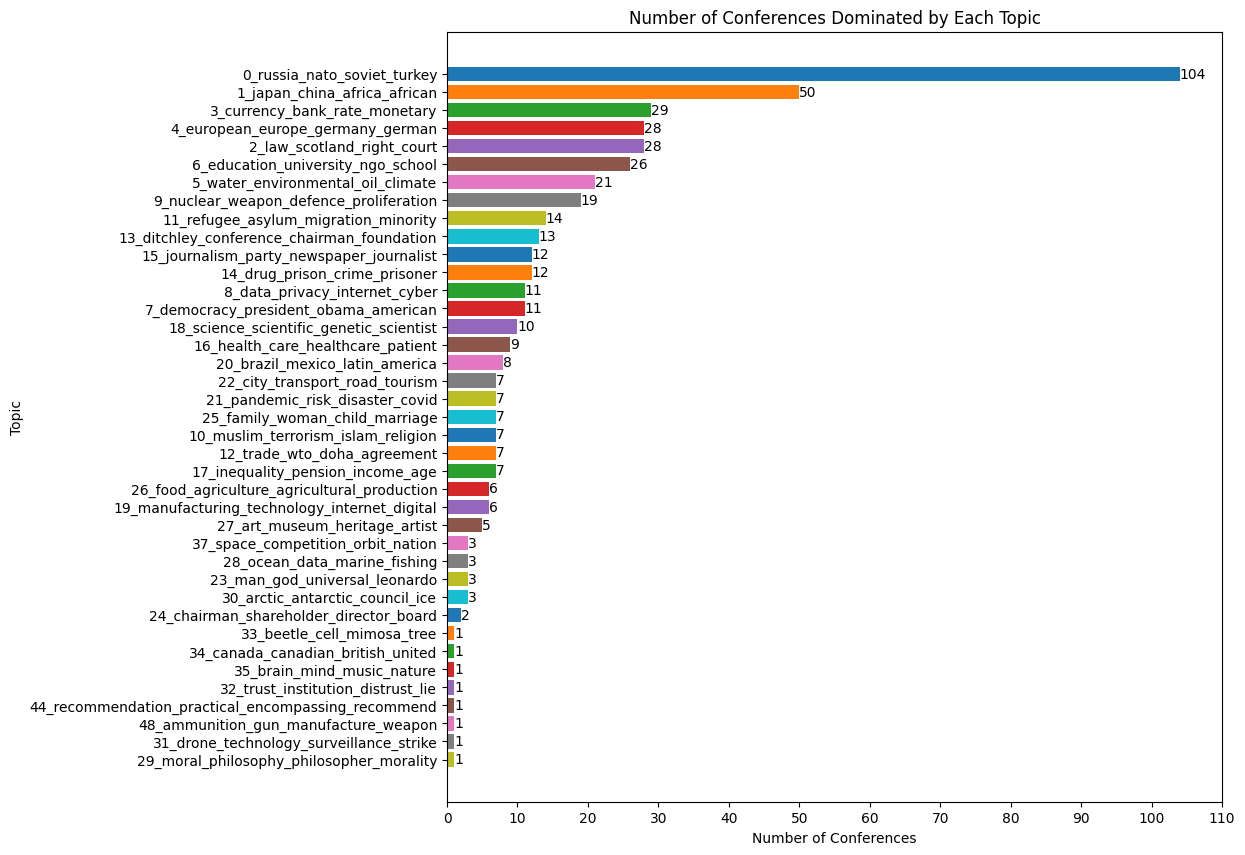

In [ ]:
# Count occurrences for 'First Rank Name'
first_rank_counts = Conferencecluster2['First Rank Name'].value_counts()

# Filter for 'Second Rank Name' where 'Distribution(2)' >= 0.3, then count occurrences
second_rank_counts = Conferencecluster2[Conferencecluster2['Distribution(2)'].astype(float) >= 0.3]['Second Rank Name'].value_counts()

# Combine counts for both 'First Rank Name' and filtered 'Second Rank Name'
total_counts = first_rank_counts.add(second_rank_counts, fill_value=0).sort_values(ascending=False)

# Generate a list of unique colors for each name
names = total_counts.index.tolist()
colors = plt.cm.tab10.colors
color_map = {name: colors[i % len(colors)] for i, name in enumerate(names)}

# Create a new figure with a specific size
plt.figure(figsize=(10, 10))

# Plot the bar chart
bars = plt.barh(total_counts.index, total_counts.values, color=[color_map[name] for name in total_counts.index])

# Add total number of titles at the end of each bar
for bar, value in zip(bars, total_counts.values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, int(value), va='center', color='black')

plt.ylabel('Topic')
plt.xlabel('Number of Conferences')
plt.title('Number of Conferences Dominated by Each Topic')

# Set x-ticks at intervals of 10
plt.xticks(np.arange(0, total_counts.max() + 10, 10))

# Reverse the y-axis if needed
plt.gca().invert_yaxis()

plt.show()


In [ ]:
# Count occurrences for 'First Rank Name'
first_rank_counts = Conferencecluster2['First Rank Name'].value_counts()

# Filter for 'Second Rank Name' where 'Distribution(2)' >= 0.3, then count occurrences
second_rank_counts = Conferencecluster2[Conferencecluster2['Distribution(2)'].astype(float) >= 0.3]['Second Rank Name'].value_counts()

# Combine counts for both 'First Rank Name' and filtered 'Second Rank Name'
total_counts = first_rank_counts.add(second_rank_counts, fill_value=0)

# Create a DataFrame with names as index
names = total_counts.index.tolist()
name_summary = pd.DataFrame(index=names)

# Add 'Total Number of Title'
name_summary['Total Number of Title'] = total_counts

# Add 'Number of Title as in First Rank' from first_rank_counts
name_summary['Number of Title as in First Rank'] = first_rank_counts

# Add 'Number of Title as in Second Rank' from second_rank_counts
name_summary['Number of Title as in Second Rank'] = second_rank_counts

# Fill NaN values with 0 if any
name_summary.fillna(0, inplace=True)

# Convert the counts to integers
name_summary = name_summary.astype(int)




In [ ]:
name_summary

Total Number of Title  \
0_russia_nato_soviet_turkey                                           104   
10_muslim_terrorism_islam_religion                                      7   
11_refugee_asylum_migration_minority                                   14   
12_trade_wto_doha_agreement                                             7   
13_ditchley_conference_chairman_foundation                             13   
14_drug_prison_crime_prisoner                                          12   
15_journalism_party_newspaper_journalist                               12   
16_health_care_healthcare_patient                                       9   
17_inequality_pension_income_age                                        7   
18_science_scientific_genetic_scientist                                10   
19_manufacturing_technology_internet_digital                            6   
1_japan_china_africa_african                                           50   
20_brazil_mexico_latin_america                                          8   
21_pandemic_risk_disaster_covid                                         7   
22_city_transport_road_tourism                                          7   
23_man_god_universal_leonardo                                           3   
24_chairman_shareholder_director_board                                  2   
25_family_woman_child_marriage                                          7   
26_food_agriculture_agricultural_production                             6   
27_art_museum_heritage_artist                                           5   
28_ocean_data_marine_fishing                                            3   
29_moral_philosophy_philosopher_morality                                1   
2_law_scotland_right_court                                             28   
30_arctic_antarctic_council_ice                                         3   
31_drone_technology_surveillance_strike                                 1   
32_trust_institution_distrust_lie                                       1   
33_beetle_cell_mimosa_tree                                              1   
34_canada_canadian_british_united                                       1   
35_brain_mind_music_nature                                              1   
37_space_competition_orbit_nation                                       3   
3_currency_bank_rate_monetary                                          29   
44_recommendation_practical_encompassing_recommend                      1   
48_ammunition_gun_manufacture_weapon                                    1   
4_european_europe_germany_german                                       28   
5_water_environmental_oil_climate                                      21   
6_education_university_ngo_school                                      26   
7_democracy_president_obama_american                                   11   
8_data_privacy_internet_cyber                                          11   
9_nuclear_weapon_defence_proliferation                                 19   

                                                    Number of Title as in First Rank  \
0_russia_nato_soviet_turkey                                                       98   
10_muslim_terrorism_islam_religion                                                 6   
11_refugee_asylum_migration_minority                                              13   
12_trade_wto_doha_agreement                                                        7   
13_ditchley_conference_chairman_foundation                                        10   
14_drug_prison_crime_prisoner                                                     11   
15_journalism_party_newspaper_journalist                                          12   
16_health_care_healthcare_patient                                                  9   
17_inequality_pension_income_age                                                   6   
18_science_scientific_genetic_scientist                                           10   
19_

In [ ]:
# Compute the sum for each column
total_summary = topic_summary.sum()

# Print the total summary
print("\nTotal Summary:")
print(total_summary)


Total Summary:
Total Number of Title                486
Number of Title as in First Rank     449
Number of Title as in Second Rank     37
dtype: int64


##Conference by themes

In [ ]:
# Function to get the cluster based on the topic number
def get_cluster(topic_num):
    for key, value in clusters.items():
        if topic_num in value:
            return key
    return None

# Count the titles where the first and second topics have different clusters and Distribution (2) >= 0.3
count_different_clusters = 0
for index, row in Conferencecluster.iterrows():
    if row['Distribution (2)'] >= 0.3:
        first_topic_cluster = get_cluster(row['First Topic'])
        second_topic_cluster = get_cluster(row['Second Topic'])
        if first_topic_cluster != second_topic_cluster:
            count_different_clusters += 1

print("Number of titles where 'First Topic' and 'Second Topic' have different clusters, and 'Distribution (2)' is >= 0.3:", count_different_clusters)


Number of titles where 'First Topic' and 'Second Topic' have different clusters, and 'Distribution (2)' is >= 0.3: 15


In [ ]:
import pandas as pd

# Initialize a DataFrame to store the counts
cluster_counts = pd.DataFrame(index=clusters.keys(), columns=list(clusters.keys()) + ['No Second Topic'])
cluster_counts.fillna(0, inplace=True)

# Function to get cluster based on topic number
def get_cluster(topic_number):
    for key, value in clusters.items():
        if topic_number in value:
            return key
    return None

# Fill the DataFrame with the counts
for index, row in Conferencecluster.iterrows():
    first_topic_cluster = get_cluster(row['First Topic'])
    second_topic_cluster = None

    if row['Distribution (2)'] >= 0.3:
        second_topic_cluster = get_cluster(row['Second Topic'])
    else:
        second_topic_cluster = 'No Second Topic'

    cluster_counts.loc[first_topic_cluster, second_topic_cluster] += 1

print(cluster_counts)


    A  B  C  D  E  F  No Second Topic
A  18  4  3  1  0  0              221
B   1  1  0  0  0  0               69
C   2  0  1  0  0  0               57
D   1  0  1  0  1  0               39
E   1  0  0  0  1  0               14
F   0  0  0  0  0  1               12


In [ ]:
original_cmap = sns.color_palette("YlGnBu", as_cmap=True)


In [ ]:
import matplotlib.colors as mcolors
import numpy as np

colors = original_cmap(np.linspace(0, 1, 256))
colors[0] = (0.9, 0.9, 0.9, 0.1)  # set the color for zero values
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)


In [ ]:
# Reordering columns so that 'No Second Topic' comes first
cols = ['No Second Topic'] + [col for col in cluster_counts if col != 'No Second Topic']
cluster_counts = cluster_counts[cols]


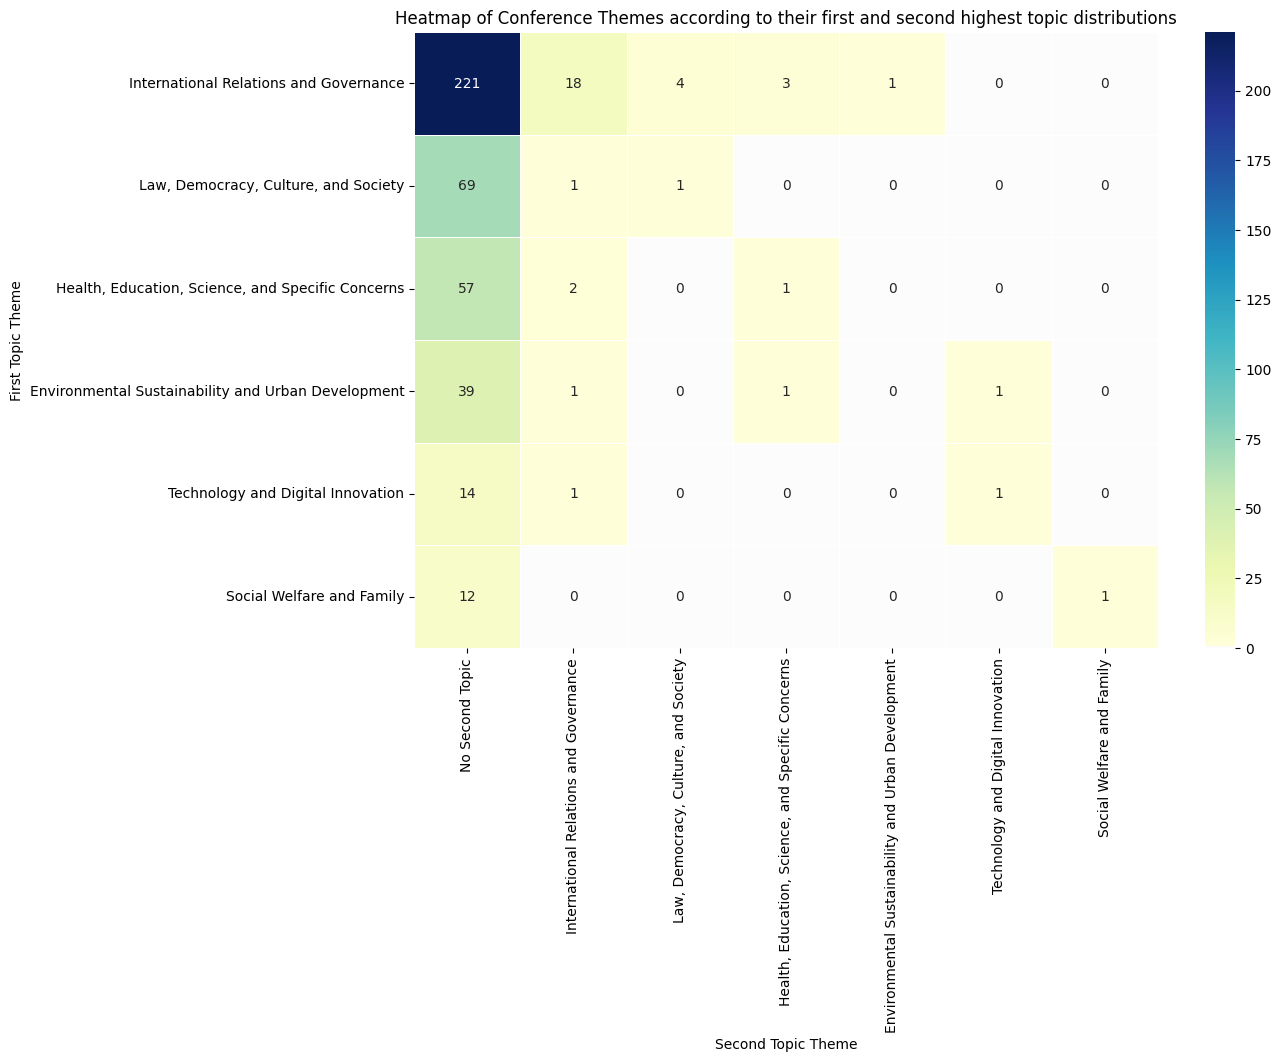

In [ ]:
# Define new labels for both axes
new_labels = {
    'A': 'International Relations and Governance',
    'B': 'Law, Democracy, Culture, and Society',
    'C': 'Health, Education, Science, and Specific Concerns',
    'D': 'Environmental Sustainability and Urban Development',
    'E': 'Technology and Digital Innovation',
    'F': 'Social Welfare and Family',
}

# Replacing index and columns with new labels
cluster_counts.rename(index=new_labels, columns=new_labels, inplace=True)
# Adding 'No Second Topic' to the column labels
cluster_counts.rename(columns={'No Second Topic': 'No Second Topic'}, inplace=True)

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_counts, annot=True, cmap=custom_cmap, fmt=".0f", linewidths=.5)
plt.ylabel('First Topic Theme')
plt.xlabel('Second Topic Theme')
plt.title('Heatmap of Conference Themes according to their first and second highest topic distributions')
plt.show()
